In [1]:
#INITIALIZING THE LIBRARIES

import pandas as pda
import numpy as npy
import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tfw
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.utils import load_img
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as pxs
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



In [2]:
##LOADING THE DATA


data = pda.read_csv("/Users/saadhameed/PycharmProjects/Capstone3/fer2013.csv")
data.shape

(35887, 3)

In [3]:
##DATA CHECK
data_check = data.isnull().sum()
print(data_check)

emotion    0
pixels     0
Usage      0
dtype: int64


In [4]:
##DATA HEAD VALIDATION
data_head = data.head()
print (data_head)

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


In [5]:
##PRE-PROCESSING OF THE DATA
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']
fig = pxs.bar(x = CLASS_LABELS,
            y = [list(data['emotion']).count(i) for i in npy.unique(data['emotion'])] ,
            color = npy.unique(data['emotion']) ,
            color_continuous_scale="Emrld")
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
   title = {
       'text': 'Train Data Distribution ',
       'y':0.95,
       'x':0.5,
       'xanchor': 'center',
       'yanchor': 'top'})
fig.show()

In [6]:
## APPLYING SAMPLING FUNCTION TO SHUFFLE THE DATA


data = data.sample(frac=1)

In [7]:
#CONVERTING CATEGORICAL LABELS INTO NUMERICAL TO OPTIMIZE THE ALGORITHM


labels = to_categorical(data[['emotion']], num_classes=7)

In [8]:
#NUMPY ARRAY CONVERSION OF IMAGE PIXELS


train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = npy.uint8(train_pixels)


In [9]:
#ARRAY STANDARDIZATION TO MAKE MEAN = & SD AS UNIT


pixels = train_pixels.reshape((35887*2304,1))


scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

In [10]:
#DATA POPULATION SPLIT
pixels = train_pixels.reshape((35887, 48, 48,1))


X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)


print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)


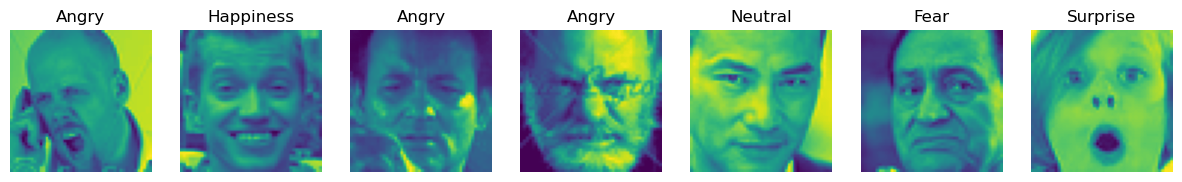

In [11]:
#DATA SAMPLE VALIDATION


plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
i = 1
for i in range (7):
   img = npy.squeeze(X_train[i])
   plt.subplot(1,7,i+1)
   plt.imshow(img)
   index = npy.argmax(y_train[i])
   plt.title(label_dict[index])
   plt.axis('off')
   i += 1
plt.show()

In [12]:
#DATA AUGMENTATION TO PREVENT OVERFITTING USING IMAGEDATAGENERATOR


datagen = ImageDataGenerator(  width_shift_range = 0.1,
                              height_shift_range = 0.1,
                              horizontal_flip = True,
                              zoom_range = 0.2)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                              height_shift_range = 0.1,
                              horizontal_flip = True,
                              zoom_range = 0.2)


datagen.fit(X_train)
valgen.fit(X_val)


train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

In [13]:
#MODEL CREATION USING CONVULOTIONAL NEURAL NETWORK CNN


def cnn_model():
   model = tfw.keras.models.Sequential()
   model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
   model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
   model.add(BatchNormalization())
   model.add(MaxPool2D(pool_size=(2, 2)))
   model.add(Dropout(0.25))


   model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
   model.add(BatchNormalization())
   model.add(MaxPool2D(pool_size=(2, 2)))
   model.add(Dropout(0.25))


   model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
   model.add(BatchNormalization())
   model.add(MaxPool2D(pool_size=(2, 2)))
   model.add(Dropout(0.25))


   model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
   model.add(BatchNormalization())
   model.add(MaxPool2D(pool_size=(2, 2)))
   model.add(Dropout(0.25))


   model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
   model.add(BatchNormalization())
   model.add(MaxPool2D(pool_size=(2, 2)))
   model.add(Dropout(0.25))


   model.add(Flatten())
   model.add(Dense(256, activation='relu'))
   model.add(BatchNormalization())
   model.add(Dropout(0.25))


   model.add(Dense(512, activation='relu'))
   model.add(BatchNormalization())
   model.add(Dropout(0.25))


   model.add(Dense(7, activation='softmax'))
   model.compile(
       optimizer=Adam(lr=0.0001),
       loss='categorical_crossentropy',
       metrics=['accuracy'])
   return model


model = cnn_model()


model.compile(
   optimizer = Adam(lr=0.0001),
   loss='categorical_crossentropy',
   metrics=['accuracy'])


model.summary()

Metal device set to: Apple M1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

In [14]:
# PREVENT OVERFITTING BY ADDING EARLY STOPPING


checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                             restore_best_weights=True,mode="max",patience = 5),
               ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                               save_best_only=True,mode="max")]


history = model.fit(train_generator,
                   epochs=30,
                   batch_size=64,
                   verbose=1,
                   callbacks=[checkpointer],
                   validation_data=val_generator)

Epoch 1/30


2023-04-09 12:56:15.595856: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


455/455 [==============================] - ETA: 0s - loss: 6.4514 - accuracy: 0.2217
Epoch 1: val_accuracy improved from -inf to 0.26378, saving model to best_model.h5
455/455 [==============================] - 64s 138ms/step - loss: 6.4514 - accuracy: 0.2217 - val_loss: 2.5464 - val_accuracy: 0.2638
Epoch 2/30
455/455 [==============================] - ETA: 0s - loss: 2.3273 - accuracy: 0.2850
Epoch 2: val_accuracy improved from 0.26378 to 0.31981, saving model to best_model.h5
455/455 [==============================] - 62s 136ms/step - loss: 2.3273 - accuracy: 0.2850 - val_loss: 2.4686 - val_accuracy: 0.3198
Epoch 3/30
455/455 [==============================] - ETA: 0s - loss: 2.4668 - accuracy: 0.3691
Epoch 3: val_accuracy improved from 0.31981 to 0.36285, saving model to best_model.h5
455/455 [==============================] - 62s 135ms/step - loss: 2.4668 - accuracy: 0.3691 - val_loss: 2.5681 - val_accuracy: 0.3628
Epoch 4/30
455/455 [==============================] - ETA: 0s - lo

113/113 [==============================] - 3s 24ms/step - loss: 1.6304 - accuracy: 0.5690
Test Acc: 0.5689607262611389
113/113 [==============================] - 3s 23ms/step


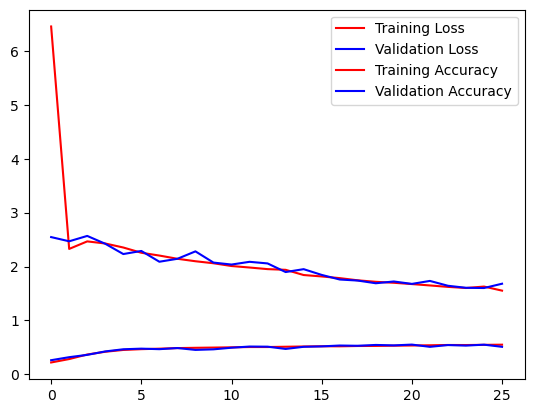

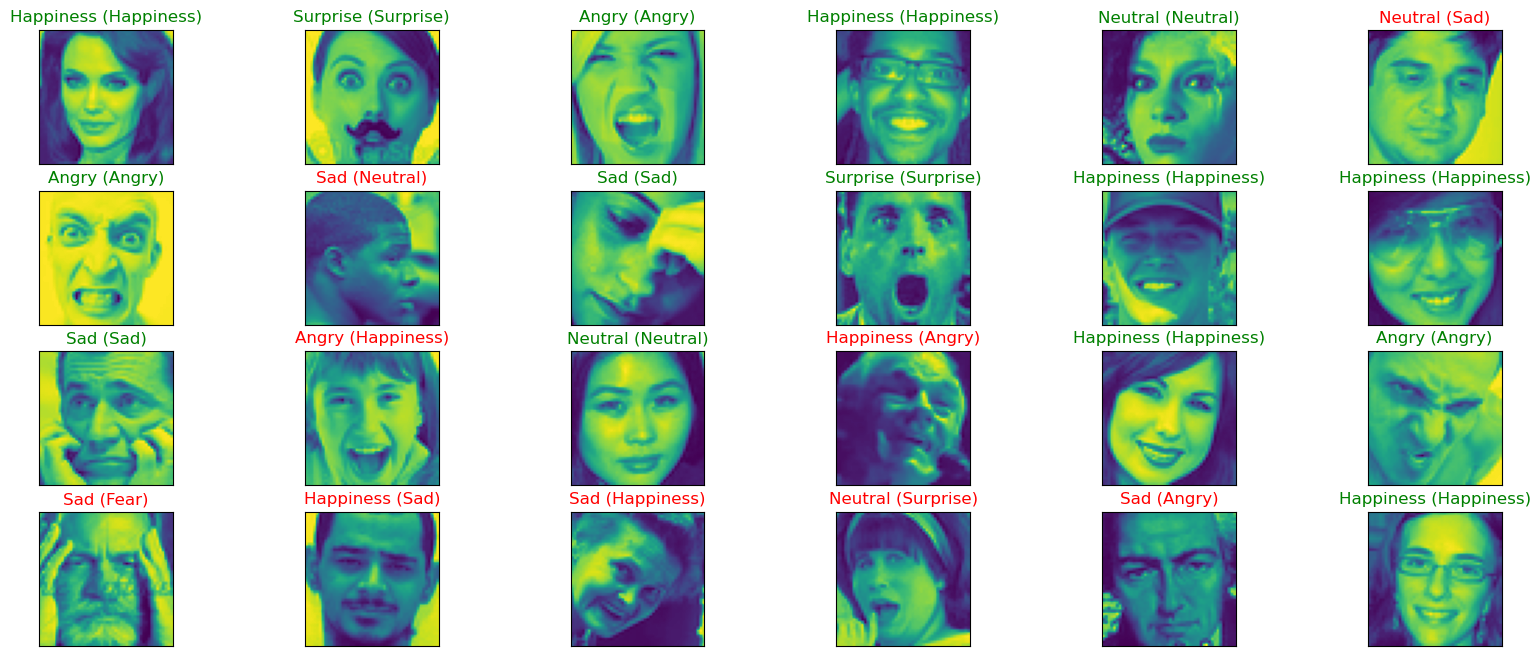

In [15]:
###VISUALIZING RESULTS FOR BASELINE CNN MODEL


plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()


plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()


loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))


preds = model.predict(X_test)
y_pred = npy.argmax(preds , axis = 1 )


label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(npy.random.choice(X_test.shape[0], size=24, replace=False)):
   ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
   ax.imshow(npy.squeeze(X_test[index]))
   predict_index = label_dict[(y_pred[index])]
   true_index = label_dict[npy.argmax(y_test, axis=1)[index]]


   ax.set_title("{} ({})".format((predict_index),
                                 (true_index)),
                color=("green" if predict_index == true_index else "red"))

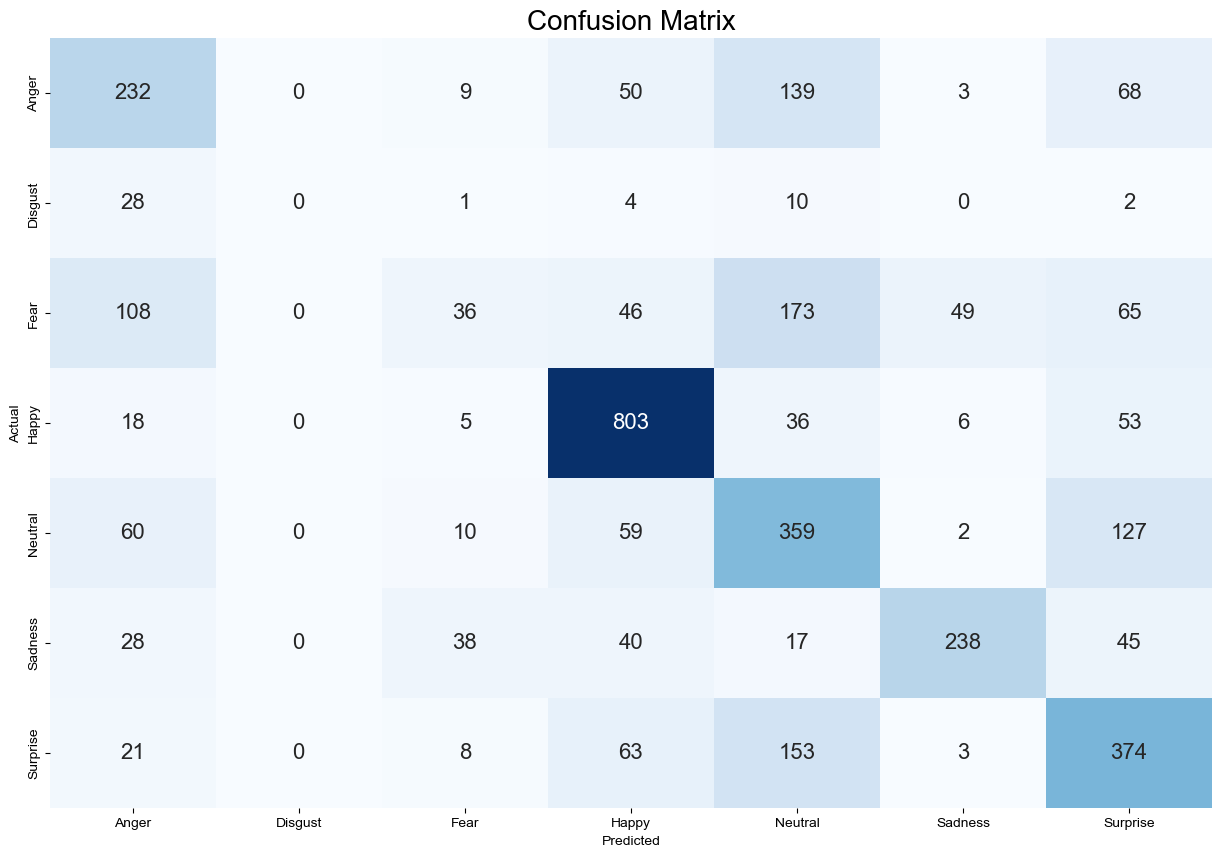

In [16]:
#CONFUSION MATRIX FOR BASELINE CNN MODEL

CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']


cm_data = confusion_matrix(npy.argmax(y_test, axis=1), y_pred)
cm = pda.DataFrame(cm_data, columns=CLASS_LABELS, index=CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(15, 10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [17]:
#PERFORMANCE METRICS FOR THE BASELINE CNN MODEL
from sklearn.metrics import classification_report
print(classification_report(npy.argmax(y_test, axis=1), y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.469     0.463     0.466       501
           1      0.000     0.000     0.000        45
           2      0.336     0.075     0.123       477
           3      0.754     0.872     0.809       921
           4      0.405     0.582     0.477       617
           5      0.791     0.586     0.673       406
           6      0.510     0.601     0.552       622

    accuracy                          0.569      3589
   macro avg      0.466     0.454     0.443      3589
weighted avg      0.551     0.569     0.543      3589



Epoch 1/30
455/455 [==============================] - ETA: 0s - loss: 14.6342 - accuracy: 0.1772
Epoch 1: val_accuracy did not improve from 0.55325
455/455 [==============================] - 61s 133ms/step - loss: 14.6342 - accuracy: 0.1772 - val_loss: 14.1397 - val_accuracy: 0.1833
Epoch 2/30
455/455 [==============================] - ETA: 0s - loss: 14.1445 - accuracy: 0.2032
Epoch 2: val_accuracy did not improve from 0.55325
455/455 [==============================] - 60s 132ms/step - loss: 14.1445 - accuracy: 0.2032 - val_loss: 13.8284 - val_accuracy: 0.1861
Epoch 3/30
455/455 [==============================] - ETA: 0s - loss: 13.7986 - accuracy: 0.2163
Epoch 3: val_accuracy did not improve from 0.55325
455/455 [==============================] - 60s 132ms/step - loss: 13.7986 - accuracy: 0.2163 - val_loss: 13.5474 - val_accuracy: 0.2226
Epoch 4/30
455/455 [==============================] - ETA: 0s - loss: 13.5187 - accuracy: 0.2261
Epoch 4: val_accuracy did not improve from 0.55325


Epoch 30/30
455/455 [==============================] - ETA: 0s - loss: 8.9086 - accuracy: 0.3240Restoring model weights from the end of the best epoch: 25.

Epoch 30: val_accuracy did not improve from 0.55325
455/455 [==============================] - 60s 133ms/step - loss: 8.9086 - accuracy: 0.3240 - val_loss: 8.9493 - val_accuracy: 0.3050
Epoch 30: early stopping
113/113 [==============================] - 3s 23ms/step - loss: 9.4962 - accuracy: 0.3349
Test Acc: 0.3349122405052185


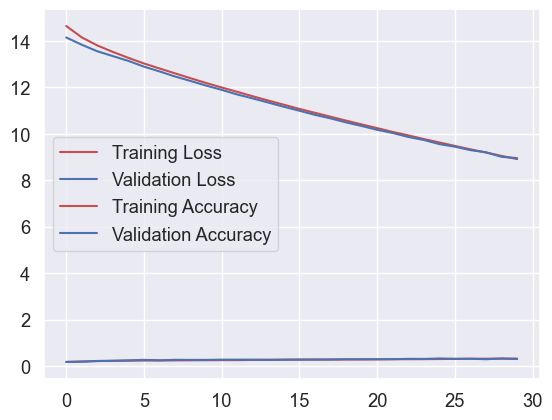

In [18]:
#BASELINE MODEL COMPARISON: USING STOCHASTIC GRADIENT DESCENT (SGD) WITH THE AIM OF COMPARING TO ADAM 

model = cnn_model()


model.compile(optimizer=tfw.keras.optimizers.SGD(0.001),
               loss='categorical_crossentropy',
               metrics = ['accuracy'])


history = model.fit(train_generator,
                   epochs=30,
                   batch_size=64,
                   verbose=1,
                   callbacks=[checkpointer],
                   validation_data=val_generator)


loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))


plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()


plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [20]:
#OPTIMIZATION- PARAMETRIC TUNING USING ADAM & INCREASING EPOCHS FROM 30 TO 50


model = cnn_model()
model.compile(
   optimizer = Adam(lr=0.0001),
   loss='categorical_crossentropy',
   metrics=['accuracy'])


checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                             restore_best_weights=True,mode="max",patience = 10),
                             ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                             save_best_only=True,mode="max")]


history = model.fit(train_generator,
                   epochs=50,
                   batch_size=64,
                   verbose=1,
                   callbacks=[checkpointer],
                   validation_data=val_generator)


loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))


preds = model.predict(X_test)
y_pred = npy.argmax(preds , axis = 1 )

Epoch 1/50
455/455 [==============================] - ETA: 0s - loss: 6.5197 - accuracy: 0.2337
Epoch 1: val_accuracy improved from -inf to 0.25263, saving model to best_model.h5
455/455 [==============================] - 64s 138ms/step - loss: 6.5197 - accuracy: 0.2337 - val_loss: 2.5822 - val_accuracy: 0.2526
Epoch 2/50
455/455 [==============================] - ETA: 0s - loss: 2.4356 - accuracy: 0.3140
Epoch 2: val_accuracy improved from 0.25263 to 0.27802, saving model to best_model.h5
455/455 [==============================] - 62s 136ms/step - loss: 2.4356 - accuracy: 0.3140 - val_loss: 2.5752 - val_accuracy: 0.2780
Epoch 3/50
455/455 [==============================] - ETA: 0s - loss: 2.5192 - accuracy: 0.3732
Epoch 3: val_accuracy improved from 0.27802 to 0.35449, saving model to best_model.h5
455/455 [==============================] - 62s 136ms/step - loss: 2.5192 - accuracy: 0.3732 - val_loss: 2.6548 - val_accuracy: 0.3545
Epoch 4/50
455/455 [==============================] - E

Epoch 29/50
455/455 [==============================] - ETA: 0s - loss: 1.5150 - accuracy: 0.5567
Epoch 29: val_accuracy did not improve from 0.56533
455/455 [==============================] - 64s 140ms/step - loss: 1.5150 - accuracy: 0.5567 - val_loss: 1.5956 - val_accuracy: 0.5412
Epoch 30/50
455/455 [==============================] - ETA: 0s - loss: 1.5110 - accuracy: 0.5587
Epoch 30: val_accuracy did not improve from 0.56533
455/455 [==============================] - 63s 139ms/step - loss: 1.5110 - accuracy: 0.5587 - val_loss: 1.5881 - val_accuracy: 0.5443
Epoch 31/50
455/455 [==============================] - ETA: 0s - loss: 1.5001 - accuracy: 0.5593
Epoch 31: val_accuracy did not improve from 0.56533
455/455 [==============================] - 63s 139ms/step - loss: 1.5001 - accuracy: 0.5593 - val_loss: 1.6010 - val_accuracy: 0.5238
Epoch 32/50
455/455 [==============================] - ETA: 0s - loss: 1.4933 - accuracy: 0.5613
Epoch 32: val_accuracy improved from 0.56533 to 0.5733

              precision    recall  f1-score   support

           0      0.519     0.547     0.533       501
           1      0.000     0.000     0.000        45
           2      0.481     0.136     0.212       477
           3      0.891     0.754     0.816       921
           4      0.390     0.640     0.485       617
           5      0.734     0.707     0.720       406
           6      0.538     0.643     0.586       622

    accuracy                          0.589      3589
   macro avg      0.508     0.490     0.479      3589
weighted avg      0.608     0.589     0.578      3589



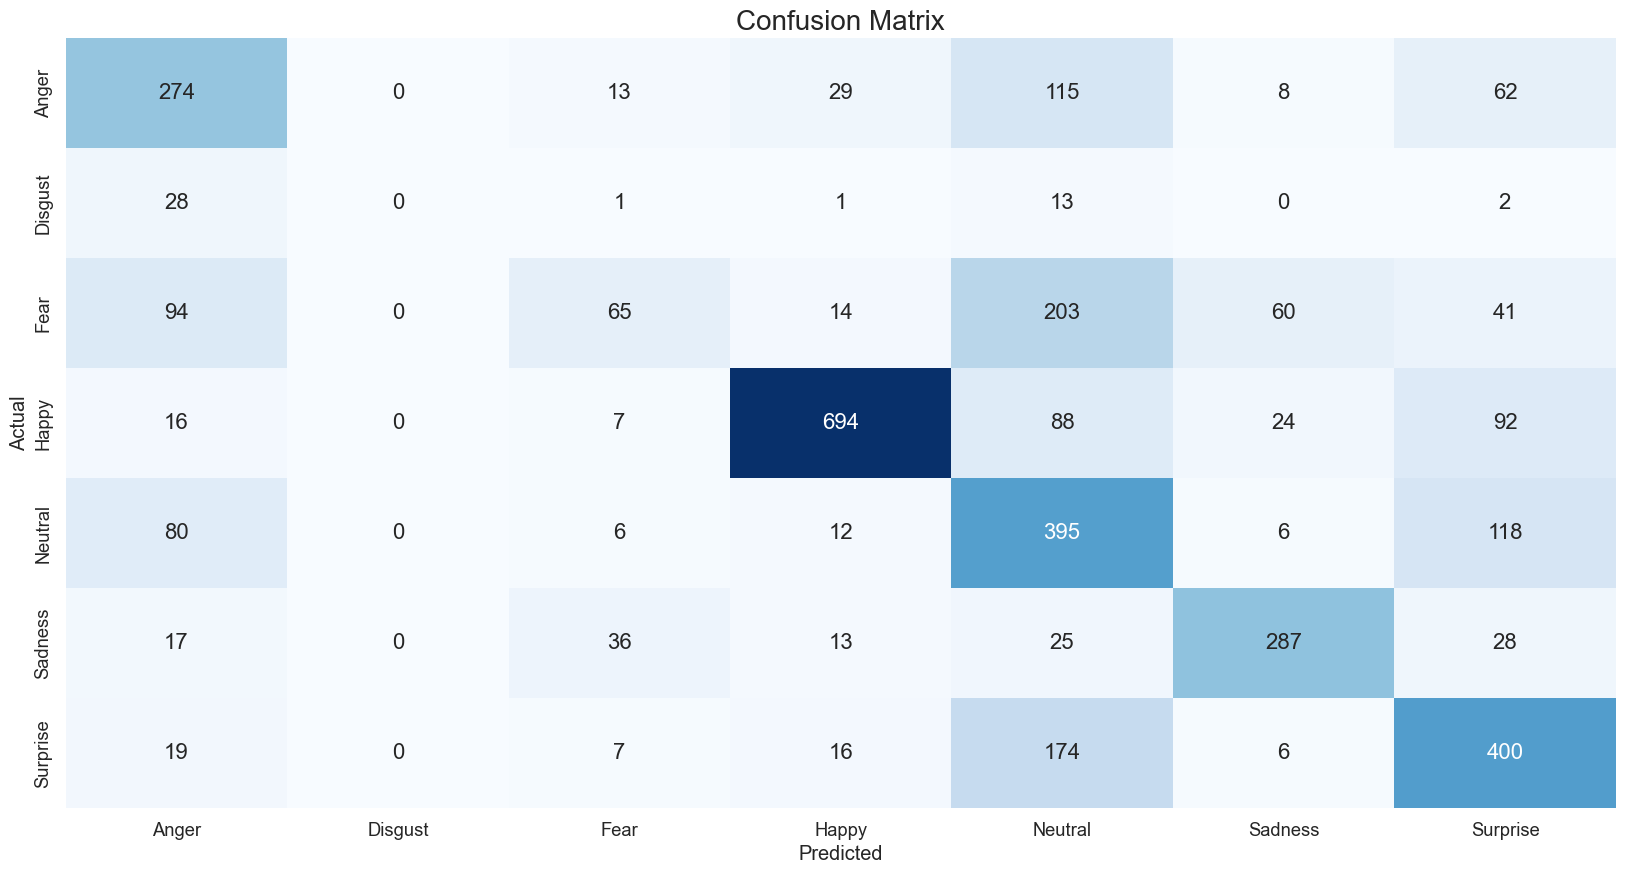

In [21]:
#CONFUSION MATRIX FOR OPTIMIZATION- PARAMETRIC TUNING USING ADAM & INCREASING EPOCHS FROM 30 TO 50
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']


cm_data = confusion_matrix(npy.argmax(y_test, axis = 1 ), y_pred)
cm = pda.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')


print(classification_report(npy.argmax(y_test, axis = 1 ),y_pred,digits=3))

In [22]:
#OPTIMIZATION- PARAMETRIC TUNING USING ADAM & INCREASING EPOCHS FROM 50 TO 75


model = cnn_model()
model.compile(
   optimizer = Adam(lr=0.0001),
   loss='categorical_crossentropy',
   metrics=['accuracy'])


checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                             restore_best_weights=True,mode="max",patience = 10),
                             ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                             save_best_only=True,mode="max")]


history = model.fit(train_generator,
                   epochs=75,
                   batch_size=64,
                   verbose=1,
                   callbacks=[checkpointer],
                   validation_data=val_generator)


loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))


preds = model.predict(X_test)
y_pred = npy.argmax(preds , axis = 1 )

Epoch 1/75
455/455 [==============================] - ETA: 0s - loss: 6.7941 - accuracy: 0.2201
Epoch 1: val_accuracy improved from -inf to 0.25542, saving model to best_model.h5
455/455 [==============================] - 64s 138ms/step - loss: 6.7941 - accuracy: 0.2201 - val_loss: 2.5170 - val_accuracy: 0.2554
Epoch 2/75
455/455 [==============================] - ETA: 0s - loss: 2.3275 - accuracy: 0.2730
Epoch 2: val_accuracy improved from 0.25542 to 0.26316, saving model to best_model.h5
455/455 [==============================] - 62s 136ms/step - loss: 2.3275 - accuracy: 0.2730 - val_loss: 2.4027 - val_accuracy: 0.2632
Epoch 3/75
455/455 [==============================] - ETA: 0s - loss: 2.3683 - accuracy: 0.3572
Epoch 3: val_accuracy improved from 0.26316 to 0.36347, saving model to best_model.h5
455/455 [==============================] - 62s 136ms/step - loss: 2.3683 - accuracy: 0.3572 - val_loss: 2.5324 - val_accuracy: 0.3635
Epoch 4/75
455/455 [==============================] - E

              precision    recall  f1-score   support

           0      0.524     0.499     0.511       501
           1      0.000     0.000     0.000        45
           2      0.462     0.191     0.270       477
           3      0.818     0.878     0.847       921
           4      0.460     0.478     0.469       617
           5      0.762     0.677     0.717       406
           6      0.496     0.736     0.593       622

    accuracy                          0.607      3589
   macro avg      0.503     0.494     0.487      3589
weighted avg      0.596     0.607     0.589      3589



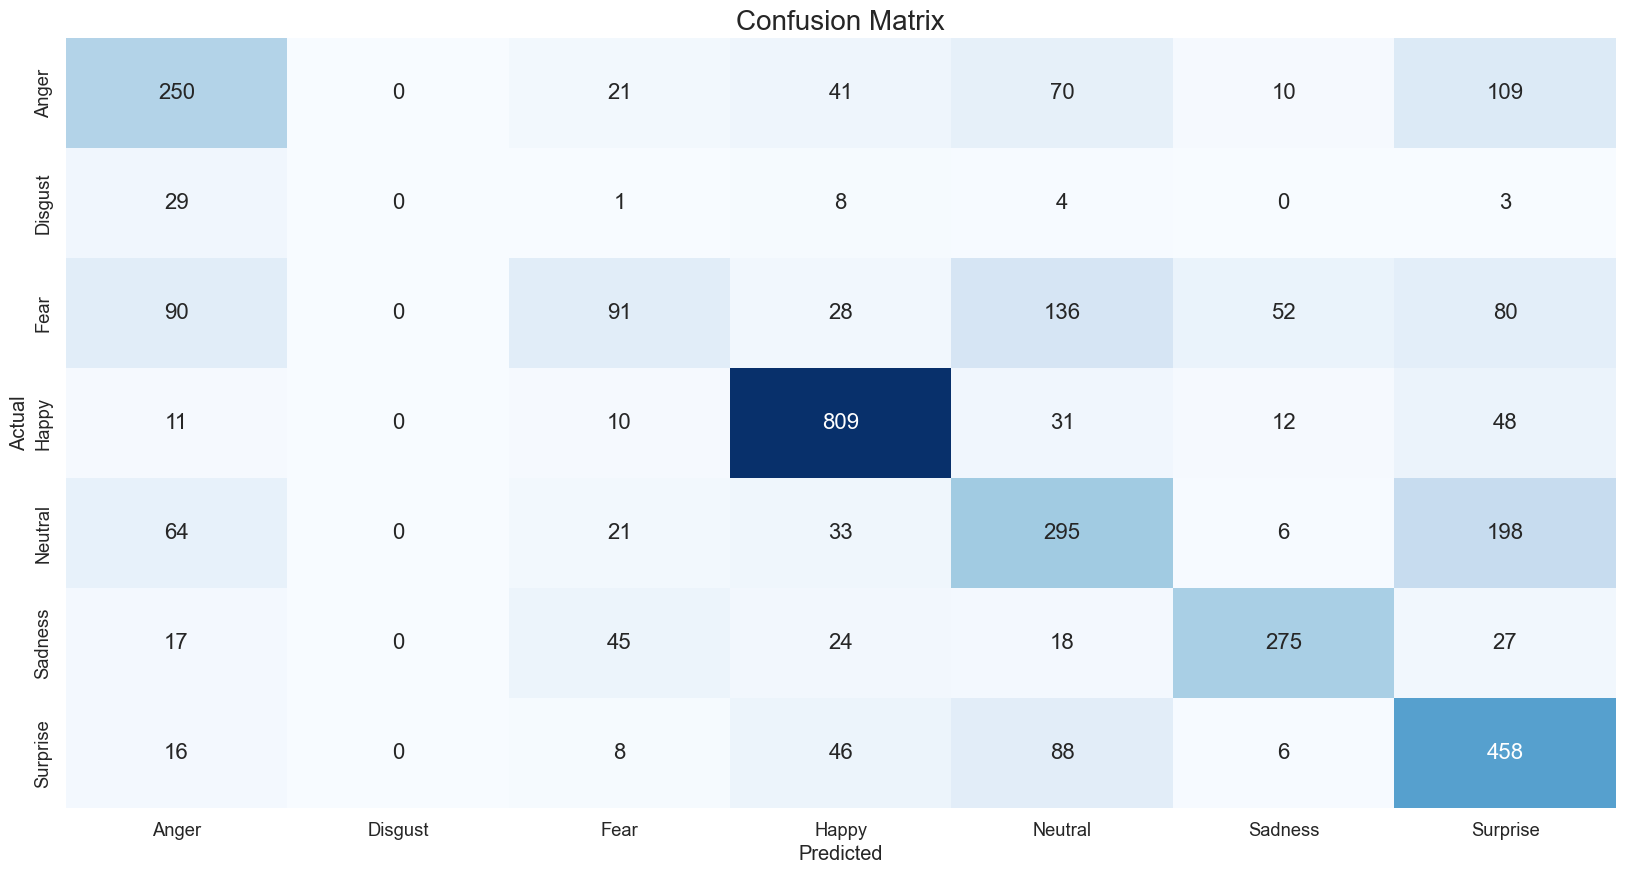

In [23]:
#CONFUSION MATRIX FOR OPTIMIZATION- PARAMETRIC TUNING USING ADAM & INCREASING EPOCHS FROM 50 TO 75
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']


cm_data = confusion_matrix(npy.argmax(y_test, axis = 1 ), y_pred)
cm = pda.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')


print(classification_report(npy.argmax(y_test, axis = 1 ),y_pred,digits=3))

In [24]:
#OPTIMIZATION- PARAMETRIC TUNING USING ADAM & DECREASING BATCH SIZE FROM 64 TO 32


model = cnn_model()
model.compile(
   optimizer = Adam(lr=0.0001),
   loss='categorical_crossentropy',
   metrics=['accuracy'])


checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                             restore_best_weights=True,mode="max",patience = 10),
                             ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                             save_best_only=True,mode="max")]


history = model.fit(train_generator,
                   epochs=75,
                   batch_size=32,
                   verbose=1,
                   callbacks=[checkpointer],
                   validation_data=val_generator)


loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))


preds = model.predict(X_test)
y_pred = npy.argmax(preds , axis = 1 )

Epoch 1/75
455/455 [==============================] - ETA: 0s - loss: 6.5428 - accuracy: 0.2244
Epoch 1: val_accuracy improved from -inf to 0.26316, saving model to best_model.h5
455/455 [==============================] - 68s 147ms/step - loss: 6.5428 - accuracy: 0.2244 - val_loss: 2.4828 - val_accuracy: 0.2632
Epoch 2/75
455/455 [==============================] - ETA: 0s - loss: 2.4120 - accuracy: 0.3082
Epoch 2: val_accuracy improved from 0.26316 to 0.26749, saving model to best_model.h5
455/455 [==============================] - 62s 136ms/step - loss: 2.4120 - accuracy: 0.3082 - val_loss: 2.8371 - val_accuracy: 0.2675
Epoch 3/75
455/455 [==============================] - ETA: 0s - loss: 2.4405 - accuracy: 0.4098
Epoch 3: val_accuracy improved from 0.26749 to 0.41765, saving model to best_model.h5
455/455 [==============================] - 62s 136ms/step - loss: 2.4405 - accuracy: 0.4098 - val_loss: 2.5261 - val_accuracy: 0.4176
Epoch 4/75
455/455 [==============================] - E

              precision    recall  f1-score   support

           0      0.509     0.553     0.530       501
           1      0.000     0.000     0.000        45
           2      0.407     0.300     0.345       477
           3      0.838     0.834     0.836       921
           4      0.460     0.433     0.446       617
           5      0.738     0.702     0.720       406
           6      0.544     0.711     0.616       622

    accuracy                          0.608      3589
   macro avg      0.500     0.505     0.499      3589
weighted avg      0.597     0.608     0.599      3589



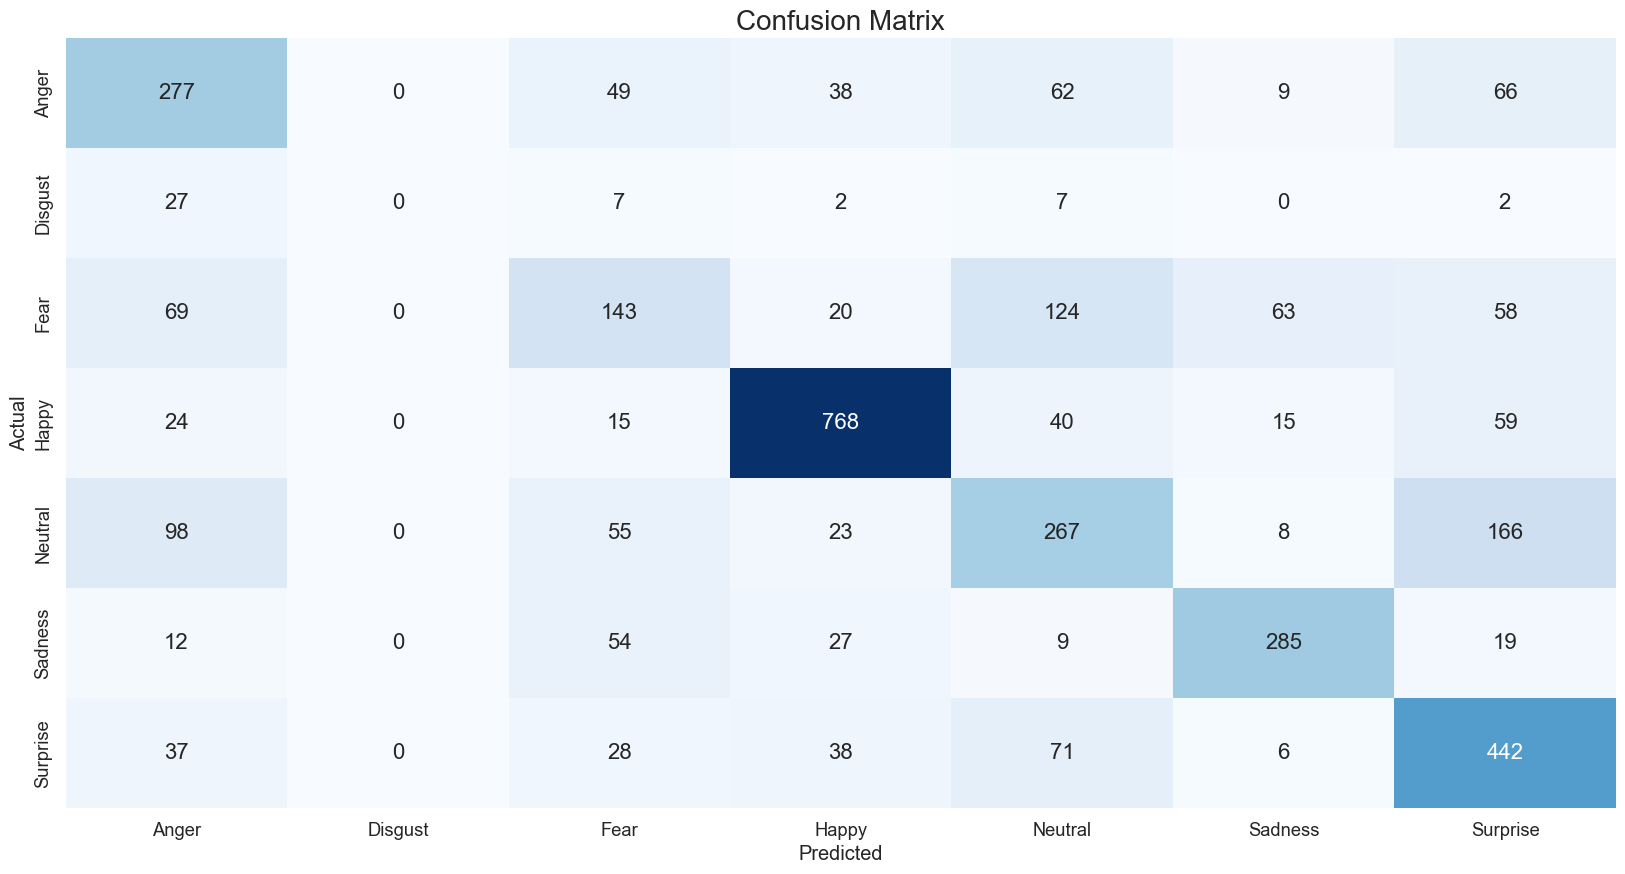

In [25]:
#CONFUSION MATRIX FOR OPTIMIZATION- PARAMETRIC TUNING USING ADAM & DECREASING BATCH SIZE FROM 64 TO 32
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']


cm_data = confusion_matrix(npy.argmax(y_test, axis = 1 ), y_pred)
cm = pda.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')


print(classification_report(npy.argmax(y_test, axis = 1 ),y_pred,digits=3))

In [26]:
#OPTIMIZATION- PARAMETRIC TUNING USING ADAM & DECREASING BATCH SIZE FROM 32 TO 16


model = cnn_model()
model.compile(
   optimizer = Adam(lr=0.0001),
   loss='categorical_crossentropy',
   metrics=['accuracy'])


checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                             restore_best_weights=True,mode="max",patience = 10),
                             ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                             save_best_only=True,mode="max")]


history = model.fit(train_generator,
                   epochs=75,
                   batch_size=16,
                   verbose=1,
                   callbacks=[checkpointer],
                   validation_data=val_generator)


loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))


preds = model.predict(X_test)
y_pred = npy.argmax(preds , axis = 1 )


Epoch 1/75
455/455 [==============================] - ETA: 0s - loss: 6.7874 - accuracy: 0.2231
Epoch 1: val_accuracy improved from -inf to 0.26409, saving model to best_model.h5
455/455 [==============================] - 67s 144ms/step - loss: 6.7874 - accuracy: 0.2231 - val_loss: 2.6822 - val_accuracy: 0.2641
Epoch 2/75
455/455 [==============================] - ETA: 0s - loss: 2.4799 - accuracy: 0.3117
Epoch 2: val_accuracy did not improve from 0.26409
455/455 [==============================] - 62s 135ms/step - loss: 2.4799 - accuracy: 0.3117 - val_loss: 3.3227 - val_accuracy: 0.2613
Epoch 3/75
455/455 [==============================] - ETA: 0s - loss: 2.5162 - accuracy: 0.3835
Epoch 3: val_accuracy improved from 0.26409 to 0.34644, saving model to best_model.h5
455/455 [==============================] - 62s 135ms/step - loss: 2.5162 - accuracy: 0.3835 - val_loss: 2.7873 - val_accuracy: 0.3464
Epoch 4/75
455/455 [==============================] - ETA: 0s - loss: 2.4148 - accuracy: 0

455/455 [==============================] - 63s 138ms/step - loss: 1.5442 - accuracy: 0.5505 - val_loss: 1.5215 - val_accuracy: 0.5601
Epoch 29/75
455/455 [==============================] - ETA: 0s - loss: 1.5272 - accuracy: 0.5526
Epoch 29: val_accuracy improved from 0.56006 to 0.56316, saving model to best_model.h5
455/455 [==============================] - 62s 137ms/step - loss: 1.5272 - accuracy: 0.5526 - val_loss: 1.5347 - val_accuracy: 0.5632
Epoch 30/75
455/455 [==============================] - ETA: 0s - loss: 1.5141 - accuracy: 0.5545
Epoch 30: val_accuracy did not improve from 0.56316
455/455 [==============================] - 62s 137ms/step - loss: 1.5141 - accuracy: 0.5545 - val_loss: 1.5367 - val_accuracy: 0.5563
Epoch 31/75
455/455 [==============================] - ETA: 0s - loss: 1.4976 - accuracy: 0.5570
Epoch 31: val_accuracy improved from 0.56316 to 0.57368, saving model to best_model.h5
455/455 [==============================] - 62s 137ms/step - loss: 1.4976 - accura

Epoch 57/75
455/455 [==============================] - ETA: 0s - loss: 1.3540 - accuracy: 0.5831
Epoch 57: val_accuracy did not improve from 0.60186
455/455 [==============================] - 62s 137ms/step - loss: 1.3540 - accuracy: 0.5831 - val_loss: 1.4452 - val_accuracy: 0.5440
Epoch 58/75
455/455 [==============================] - ETA: 0s - loss: 1.3509 - accuracy: 0.5827
Epoch 58: val_accuracy improved from 0.60186 to 0.60557, saving model to best_model.h5
455/455 [==============================] - 62s 136ms/step - loss: 1.3509 - accuracy: 0.5827 - val_loss: 1.3247 - val_accuracy: 0.6056
Epoch 59/75
455/455 [==============================] - ETA: 0s - loss: 1.3464 - accuracy: 0.5866
Epoch 59: val_accuracy did not improve from 0.60557
455/455 [==============================] - 62s 136ms/step - loss: 1.3464 - accuracy: 0.5866 - val_loss: 1.3390 - val_accuracy: 0.5960
Epoch 60/75
455/455 [==============================] - ETA: 0s - loss: 1.3373 - accuracy: 0.5866
Epoch 60: val_accur

              precision    recall  f1-score   support

           0      0.543     0.491     0.516       501
           1      0.667     0.044     0.083        45
           2      0.471     0.241     0.319       477
           3      0.817     0.848     0.832       921
           4      0.501     0.464     0.481       617
           5      0.634     0.798     0.707       406
           6      0.517     0.707     0.597       622

    accuracy                          0.611      3589
   macro avg      0.593     0.513     0.505      3589
weighted avg      0.604     0.611     0.595      3589



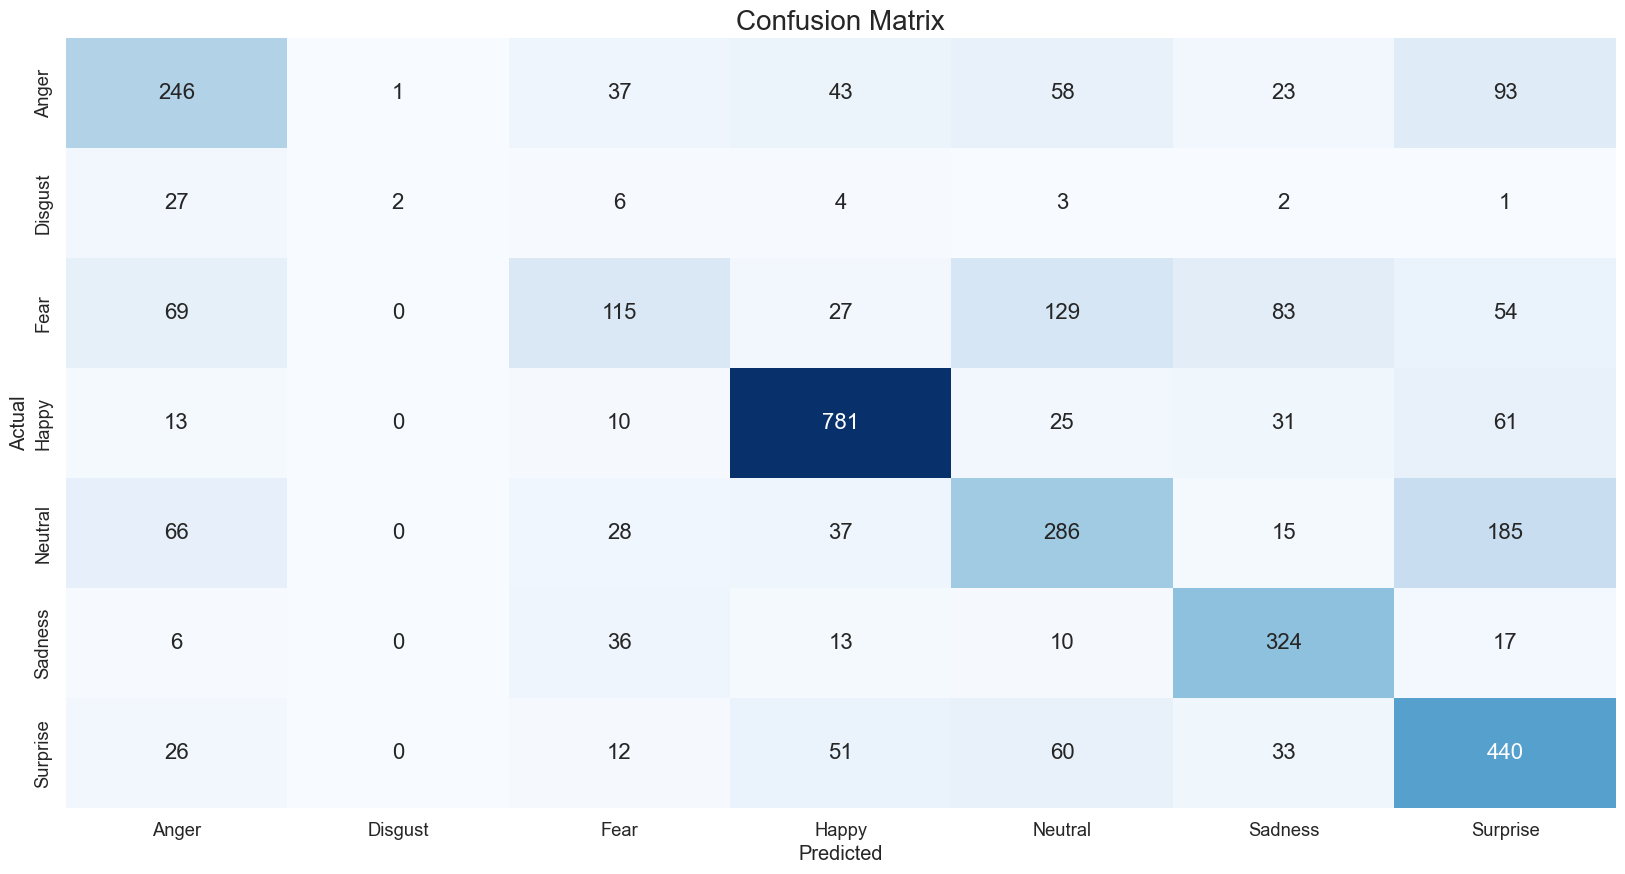

In [32]:
#CONFUSION MATRIX FOR OPTIMIZATION- PARAMETRIC TUNING USING ADAM & DECREASING BATCH SIZE FROM 32 TO 16
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']


cm_data = confusion_matrix(npy.argmax(y_test, axis = 1 ), y_pred)
cm = pda.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')


print(classification_report(npy.argmax(y_test, axis = 1 ),y_pred,digits=3))

In [27]:
#OPTIMIZATION- PARAMETRIC TUNING USING ADAM & DECREASING BATCH SIZE FROM 16 TO 8


model = cnn_model()
model.compile(
   optimizer = Adam(lr=0.0001),
   loss='categorical_crossentropy',
   metrics=['accuracy'])


checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                             restore_best_weights=True,mode="max",patience = 10),
                             ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                             save_best_only=True,mode="max")]


history = model.fit(train_generator,
                   epochs=75,
                   batch_size=8,
                   verbose=1,
                   callbacks=[checkpointer],
                   validation_data=val_generator)


loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))


preds = model.predict(X_test)
y_pred = npy.argmax(preds , axis = 1 )

Epoch 1/75
455/455 [==============================] - ETA: 0s - loss: 6.6387 - accuracy: 0.2262
Epoch 1: val_accuracy improved from -inf to 0.26130, saving model to best_model.h5
455/455 [==============================] - 66s 140ms/step - loss: 6.6387 - accuracy: 0.2262 - val_loss: 2.5867 - val_accuracy: 0.2613
Epoch 2/75
455/455 [==============================] - ETA: 0s - loss: 2.4447 - accuracy: 0.3180
Epoch 2: val_accuracy improved from 0.26130 to 0.29814, saving model to best_model.h5
455/455 [==============================] - 62s 137ms/step - loss: 2.4447 - accuracy: 0.3180 - val_loss: 2.7736 - val_accuracy: 0.2981
Epoch 3/75
455/455 [==============================] - ETA: 0s - loss: 2.4899 - accuracy: 0.4137
Epoch 3: val_accuracy improved from 0.29814 to 0.39102, saving model to best_model.h5
455/455 [==============================] - 62s 137ms/step - loss: 2.4899 - accuracy: 0.4137 - val_loss: 2.6658 - val_accuracy: 0.3910
Epoch 4/75
455/455 [==============================] - E

Epoch 29/75
455/455 [==============================] - ETA: 0s - loss: 1.5111 - accuracy: 0.5601
Epoch 29: val_accuracy did not improve from 0.57337
455/455 [==============================] - 62s 136ms/step - loss: 1.5111 - accuracy: 0.5601 - val_loss: 1.5032 - val_accuracy: 0.5588
Epoch 30/75
455/455 [==============================] - ETA: 0s - loss: 1.4829 - accuracy: 0.5626
Epoch 30: val_accuracy improved from 0.57337 to 0.57740, saving model to best_model.h5
455/455 [==============================] - 62s 137ms/step - loss: 1.4829 - accuracy: 0.5626 - val_loss: 1.4875 - val_accuracy: 0.5774
Epoch 31/75
455/455 [==============================] - ETA: 0s - loss: 1.4971 - accuracy: 0.5633
Epoch 31: val_accuracy did not improve from 0.57740
455/455 [==============================] - 62s 136ms/step - loss: 1.4971 - accuracy: 0.5633 - val_loss: 1.5681 - val_accuracy: 0.5269
Epoch 32/75
455/455 [==============================] - ETA: 0s - loss: 1.4835 - accuracy: 0.5645
Epoch 32: val_accur

              precision    recall  f1-score   support

           0      0.542     0.507     0.524       501
           1      0.500     0.022     0.043        45
           2      0.472     0.210     0.290       477
           3      0.842     0.860     0.851       921
           4      0.465     0.499     0.482       617
           5      0.719     0.744     0.731       406
           6      0.520     0.738     0.610       622

    accuracy                          0.617      3589
   macro avg      0.580     0.511     0.504      3589
weighted avg      0.612     0.617     0.602      3589



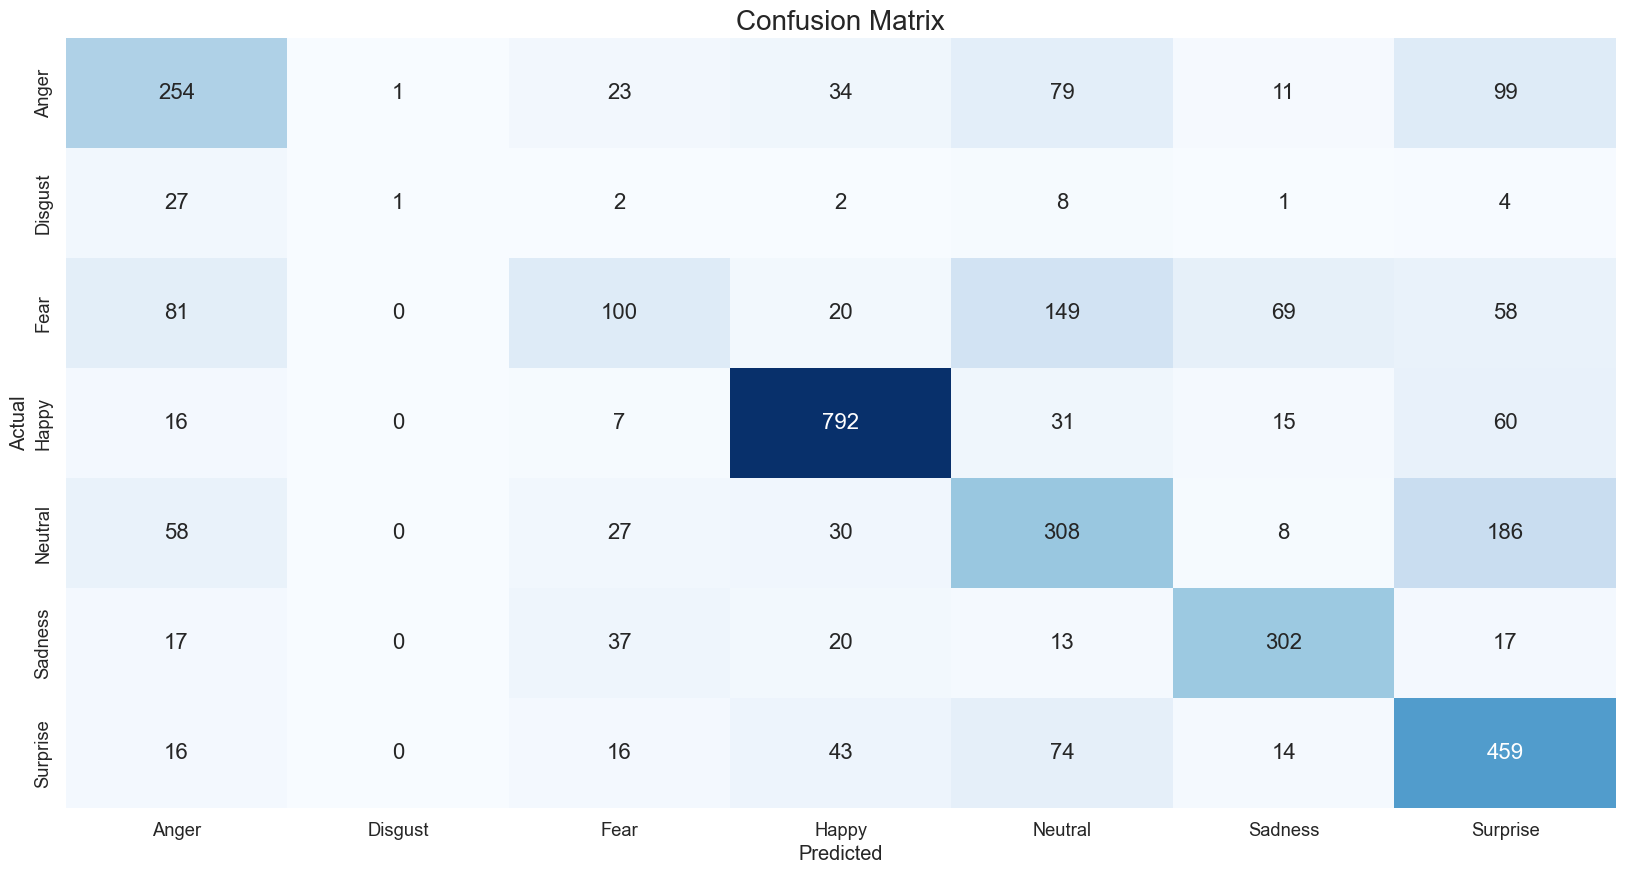

In [29]:
#CONFUSION MATRIX FOR OPTIMIZATION- PARAMETRIC TUNING USING ADAM & DECREASING BATCH SIZE FROM 16 TO 8
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']


cm_data = confusion_matrix(npy.argmax(y_test, axis = 1 ), y_pred)
cm = pda.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')


print(classification_report(npy.argmax(y_test, axis = 1 ),y_pred,digits=3))

In [28]:
#OPTIMIZATION- PARAMETRIC TUNING USING ADAM, BATCH SIZE 16 AND INCREASED LR APROACH FROM 0.00001 TO LR 0.0002


model = cnn_model()
model.compile(
   optimizer = Adam(lr=0.0002),
   loss='categorical_crossentropy',
   metrics=['accuracy'])


checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                             restore_best_weights=True,mode="max",patience = 10),
                             ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                             save_best_only=True,mode="max")]


history = model.fit(train_generator,
                   epochs=75,
                   batch_size=16,
                   verbose=1,
                   callbacks=[checkpointer],
                   validation_data=val_generator)


loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))


preds = model.predict(X_test)
y_pred = npy.argmax(preds , axis = 1 )

Epoch 1/75
455/455 [==============================] - ETA: 0s - loss: 6.5928 - accuracy: 0.2219
Epoch 1: val_accuracy improved from -inf to 0.23220, saving model to best_model.h5
455/455 [==============================] - 65s 140ms/step - loss: 6.5928 - accuracy: 0.2219 - val_loss: 2.5541 - val_accuracy: 0.2322
Epoch 2/75
455/455 [==============================] - ETA: 0s - loss: 2.4391 - accuracy: 0.3119
Epoch 2: val_accuracy did not improve from 0.23220
455/455 [==============================] - 62s 136ms/step - loss: 2.4391 - accuracy: 0.3119 - val_loss: 2.7482 - val_accuracy: 0.2279
Epoch 3/75
455/455 [==============================] - ETA: 0s - loss: 2.5298 - accuracy: 0.4016
Epoch 3: val_accuracy improved from 0.23220 to 0.31207, saving model to best_model.h5
455/455 [==============================] - 62s 136ms/step - loss: 2.5298 - accuracy: 0.4016 - val_loss: 2.7292 - val_accuracy: 0.3121
Epoch 4/75
455/455 [==============================] - ETA: 0s - loss: 2.4539 - accuracy: 0

Epoch 29/75
455/455 [==============================] - ETA: 0s - loss: 1.4949 - accuracy: 0.5598
Epoch 29: val_accuracy did not improve from 0.57926
455/455 [==============================] - 62s 136ms/step - loss: 1.4949 - accuracy: 0.5598 - val_loss: 1.4806 - val_accuracy: 0.5693
Epoch 30/75
455/455 [==============================] - ETA: 0s - loss: 1.4924 - accuracy: 0.5575
Epoch 30: val_accuracy did not improve from 0.57926
455/455 [==============================] - 62s 136ms/step - loss: 1.4924 - accuracy: 0.5575 - val_loss: 1.5145 - val_accuracy: 0.5684
Epoch 31/75
455/455 [==============================] - ETA: 0s - loss: 1.4721 - accuracy: 0.5639
Epoch 31: val_accuracy did not improve from 0.57926
455/455 [==============================] - 62s 136ms/step - loss: 1.4721 - accuracy: 0.5639 - val_loss: 1.4889 - val_accuracy: 0.5452
Epoch 32/75
455/455 [==============================] - ETA: 0s - loss: 1.4745 - accuracy: 0.5634
Epoch 32: val_accuracy did not improve from 0.57926
45

455/455 [==============================] - 62s 135ms/step - loss: 1.3310 - accuracy: 0.5830 - val_loss: 1.3701 - val_accuracy: 0.5768
Epoch 58/75
455/455 [==============================] - ETA: 0s - loss: 1.3239 - accuracy: 0.5873
Epoch 58: val_accuracy did not improve from 0.60588
455/455 [==============================] - 62s 136ms/step - loss: 1.3239 - accuracy: 0.5873 - val_loss: 1.3456 - val_accuracy: 0.5765
Epoch 59/75
455/455 [==============================] - ETA: 0s - loss: 1.3255 - accuracy: 0.5862
Epoch 59: val_accuracy did not improve from 0.60588
455/455 [==============================] - 62s 136ms/step - loss: 1.3255 - accuracy: 0.5862 - val_loss: 1.2965 - val_accuracy: 0.5988
Epoch 60/75
455/455 [==============================] - ETA: 0s - loss: 1.3209 - accuracy: 0.5877Restoring model weights from the end of the best epoch: 50.

Epoch 60: val_accuracy did not improve from 0.60588
455/455 [==============================] - 62s 136ms/step - loss: 1.3209 - accuracy: 0.5877

              precision    recall  f1-score   support

           0      0.542     0.507     0.524       501
           1      0.500     0.022     0.043        45
           2      0.472     0.210     0.290       477
           3      0.842     0.860     0.851       921
           4      0.465     0.499     0.482       617
           5      0.719     0.744     0.731       406
           6      0.520     0.738     0.610       622

    accuracy                          0.617      3589
   macro avg      0.580     0.511     0.504      3589
weighted avg      0.612     0.617     0.602      3589



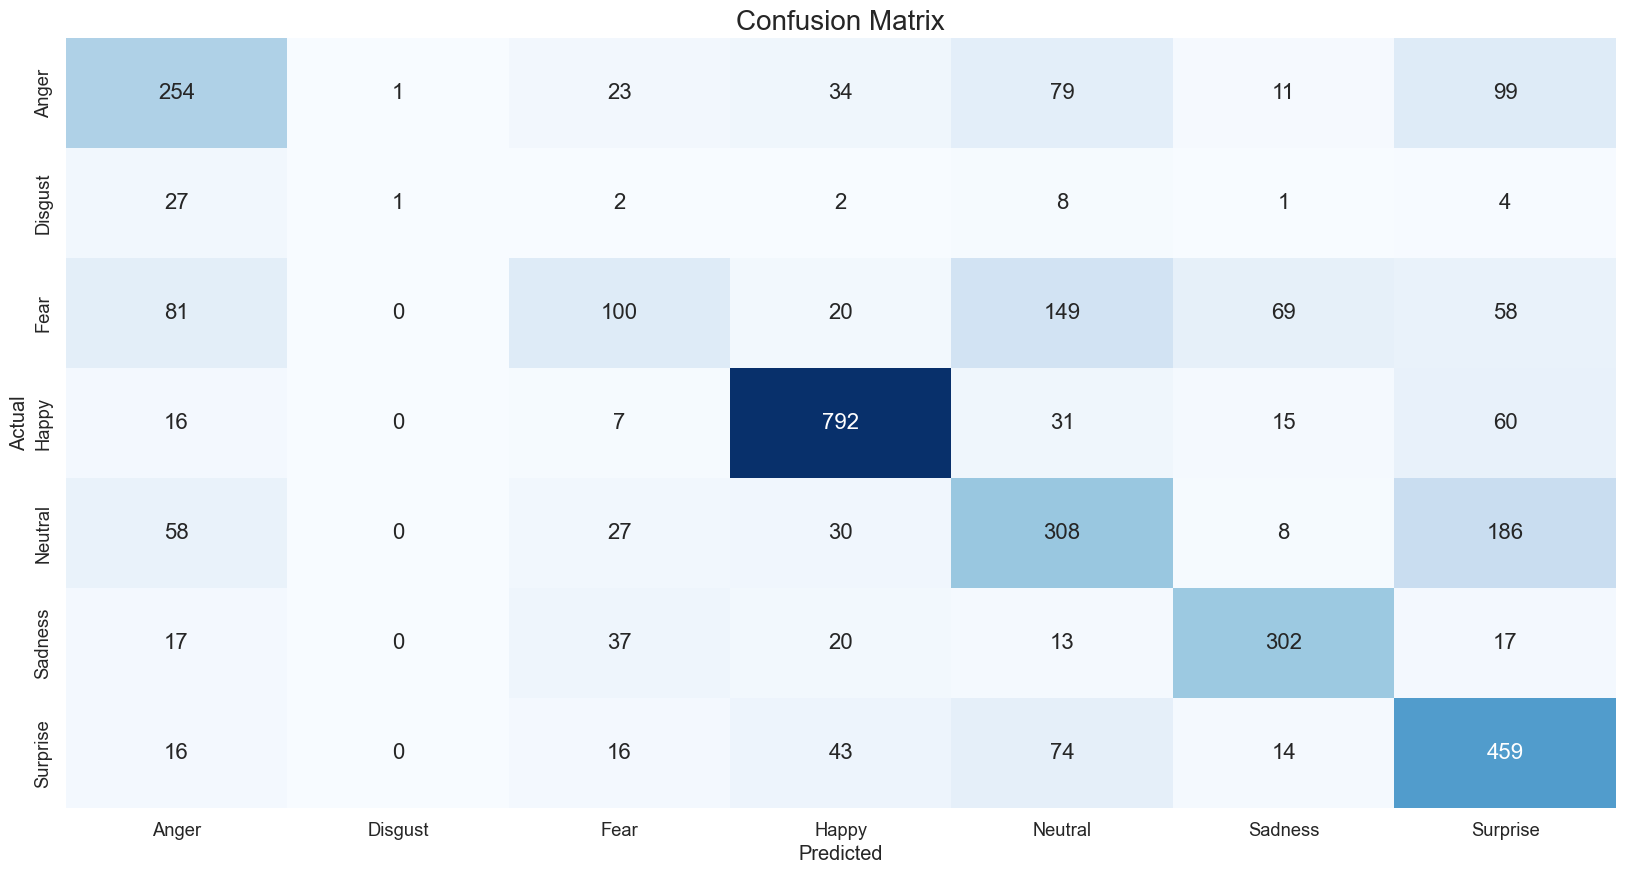

In [30]:
#CONFUSION MATRIX FOR OPTIMIZATION- PARAMETRIC TUNING USING ADAM, BATCH SIZE 16 AND INCREASED LR APROACH FROM 0.00001 TO LR 0.0002
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']


cm_data = confusion_matrix(npy.argmax(y_test, axis = 1 ), y_pred)
cm = pda.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')


print(classification_report(npy.argmax(y_test, axis = 1 ),y_pred,digits=3))

In [31]:
#OPTIMIZATION- PARAMETRIC TUNING USING ADAM, BATCH SIZE 16 AND INCREASED LR APROACH FROM 0.00001 TO LR 0.0009


model = cnn_model()
model.compile(
   optimizer = Adam(lr=0.0009),
   loss='categorical_crossentropy',
   metrics=['accuracy'])


checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                             restore_best_weights=True,mode="max",patience = 10),
                             ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                             save_best_only=True,mode="max")]


history = model.fit(train_generator,
                   epochs=75,
                   batch_size=16,
                   verbose=1,
                   callbacks=[checkpointer],
                   validation_data=val_generator)


loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))


preds = model.predict(X_test)
y_pred = npy.argmax(preds , axis = 1 )

Epoch 1/75
455/455 [==============================] - ETA: 0s - loss: 6.4034 - accuracy: 0.2175
Epoch 1: val_accuracy improved from -inf to 0.25666, saving model to best_model.h5
455/455 [==============================] - 67s 143ms/step - loss: 6.4034 - accuracy: 0.2175 - val_loss: 2.3257 - val_accuracy: 0.2567
Epoch 2/75
455/455 [==============================] - ETA: 0s - loss: 2.3295 - accuracy: 0.2829
Epoch 2: val_accuracy did not improve from 0.25666
455/455 [==============================] - 62s 136ms/step - loss: 2.3295 - accuracy: 0.2829 - val_loss: 2.5185 - val_accuracy: 0.2142
Epoch 3/75
455/455 [==============================] - ETA: 0s - loss: 2.4739 - accuracy: 0.3875
Epoch 3: val_accuracy improved from 0.25666 to 0.34923, saving model to best_model.h5
455/455 [==============================] - 64s 140ms/step - loss: 2.4739 - accuracy: 0.3875 - val_loss: 2.6394 - val_accuracy: 0.3492
Epoch 4/75
455/455 [==============================] - ETA: 0s - loss: 2.3312 - accuracy: 0

Epoch 29/75
455/455 [==============================] - ETA: 0s - loss: 1.4979 - accuracy: 0.5567
Epoch 29: val_accuracy did not improve from 0.57647
455/455 [==============================] - 62s 136ms/step - loss: 1.4979 - accuracy: 0.5567 - val_loss: 1.5214 - val_accuracy: 0.5443
Epoch 30/75
455/455 [==============================] - ETA: 0s - loss: 1.4885 - accuracy: 0.5587
Epoch 30: val_accuracy did not improve from 0.57647
455/455 [==============================] - 62s 136ms/step - loss: 1.4885 - accuracy: 0.5587 - val_loss: 1.4842 - val_accuracy: 0.5678
Epoch 31/75
455/455 [==============================] - ETA: 0s - loss: 1.4761 - accuracy: 0.5631
Epoch 31: val_accuracy did not improve from 0.57647
455/455 [==============================] - 62s 136ms/step - loss: 1.4761 - accuracy: 0.5631 - val_loss: 1.4697 - val_accuracy: 0.5697
Epoch 32/75
455/455 [==============================] - ETA: 0s - loss: 1.4636 - accuracy: 0.5638
Epoch 32: val_accuracy did not improve from 0.57647
45

              precision    recall  f1-score   support

           0      0.543     0.491     0.516       501
           1      0.667     0.044     0.083        45
           2      0.471     0.241     0.319       477
           3      0.817     0.848     0.832       921
           4      0.501     0.464     0.481       617
           5      0.634     0.798     0.707       406
           6      0.517     0.707     0.597       622

    accuracy                          0.611      3589
   macro avg      0.593     0.513     0.505      3589
weighted avg      0.604     0.611     0.595      3589



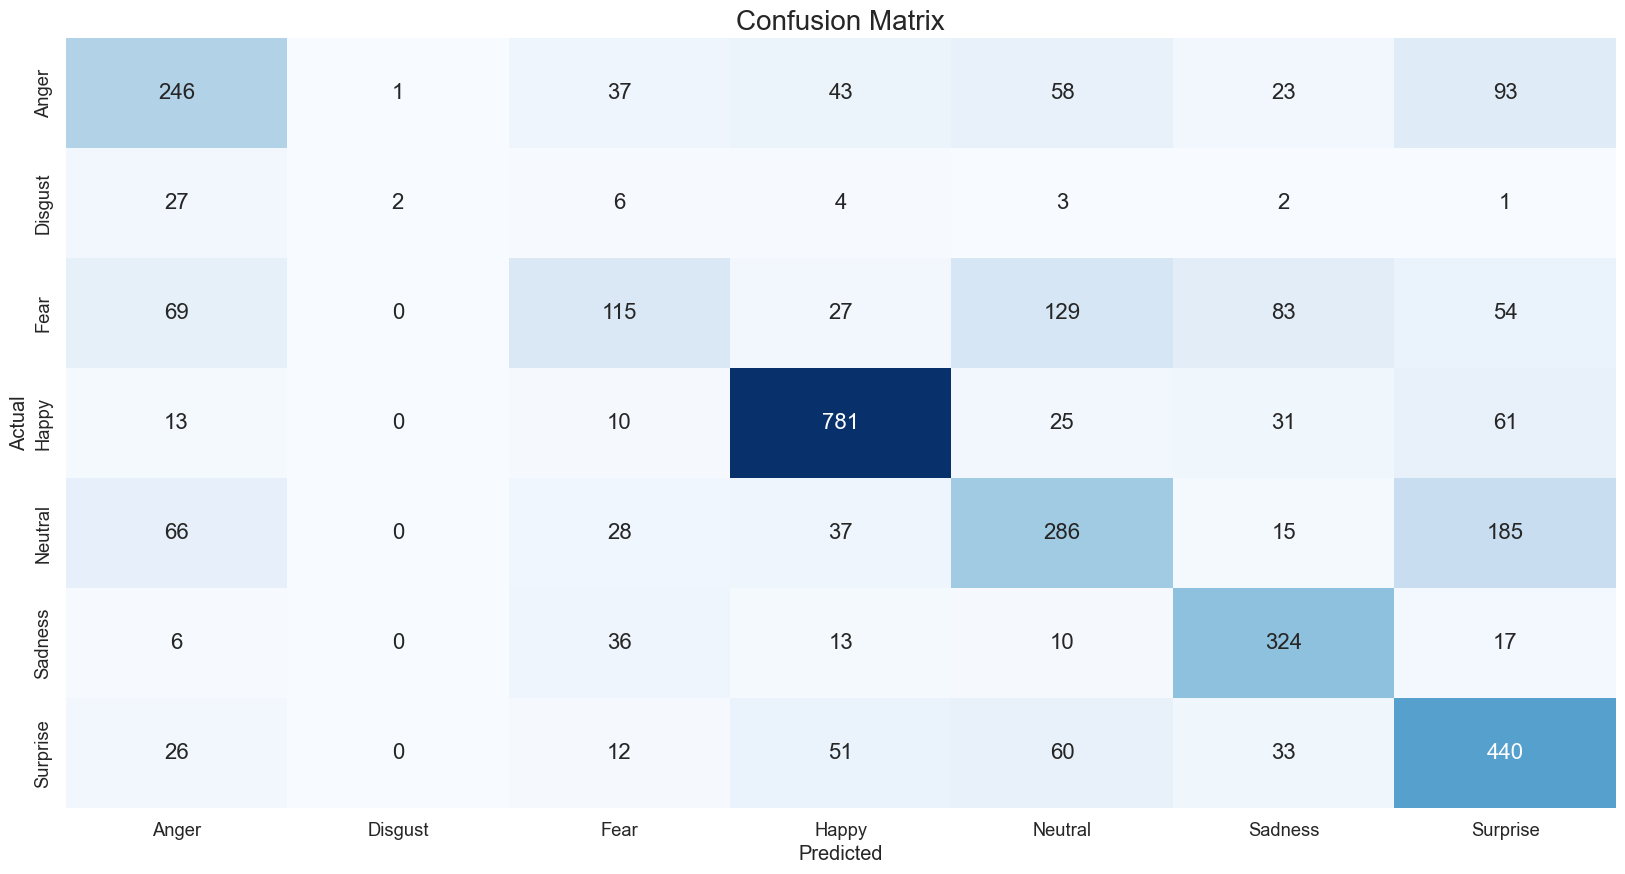

In [33]:
#CONFUSION MATRIX FOR OPTIMIZATION- PARAMETRIC TUNING USING ADAM, BATCH SIZE 16 AND INCREASED LR APROACH FROM 0.00001 TO LR 0.0009
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']


cm_data = confusion_matrix(npy.argmax(y_test, axis = 1 ), y_pred)
cm = pda.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')


print(classification_report(npy.argmax(y_test, axis = 1 ),y_pred,digits=3))

In [34]:
#OPTIMIZATION- PARAMETRIC TUNING USING ADAM, BATCH SIZE 16 AND INCREASED LR APROACH FROM 0.00001 TO LR 0.001


model = cnn_model()
model.compile(
   optimizer = Adam(lr=0.001),
   loss='categorical_crossentropy',
   metrics=['accuracy'])


checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                             restore_best_weights=True,mode="max",patience = 10),
                             ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                             save_best_only=True,mode="max")]


history = model.fit(train_generator,
                   epochs=75,
                   batch_size=16,
                   verbose=1,
                   callbacks=[checkpointer],
                   validation_data=val_generator)


loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))


preds = model.predict(X_test)
y_pred = npy.argmax(preds , axis = 1 )

Epoch 1/75
455/455 [==============================] - ETA: 0s - loss: 6.4235 - accuracy: 0.2163
Epoch 1: val_accuracy improved from -inf to 0.25108, saving model to best_model.h5
455/455 [==============================] - 67s 143ms/step - loss: 6.4235 - accuracy: 0.2163 - val_loss: 2.3435 - val_accuracy: 0.2511
Epoch 2/75
455/455 [==============================] - ETA: 0s - loss: 2.2797 - accuracy: 0.2712
Epoch 2: val_accuracy improved from 0.25108 to 0.26254, saving model to best_model.h5
455/455 [==============================] - 62s 137ms/step - loss: 2.2797 - accuracy: 0.2712 - val_loss: 2.5673 - val_accuracy: 0.2625
Epoch 3/75
455/455 [==============================] - ETA: 0s - loss: 2.4224 - accuracy: 0.3624
Epoch 3: val_accuracy improved from 0.26254 to 0.34241, saving model to best_model.h5
455/455 [==============================] - 62s 137ms/step - loss: 2.4224 - accuracy: 0.3624 - val_loss: 2.5408 - val_accuracy: 0.3424
Epoch 4/75
455/455 [==============================] - E

              precision    recall  f1-score   support

           0      0.509     0.487     0.498       501
           1      0.000     0.000     0.000        45
           2      0.381     0.224     0.282       477
           3      0.811     0.857     0.833       921
           4      0.468     0.522     0.493       617
           5      0.703     0.746     0.724       406
           6      0.564     0.669     0.612       622

    accuracy                          0.608      3589
   macro avg      0.491     0.501     0.492      3589
weighted avg      0.588     0.608     0.594      3589



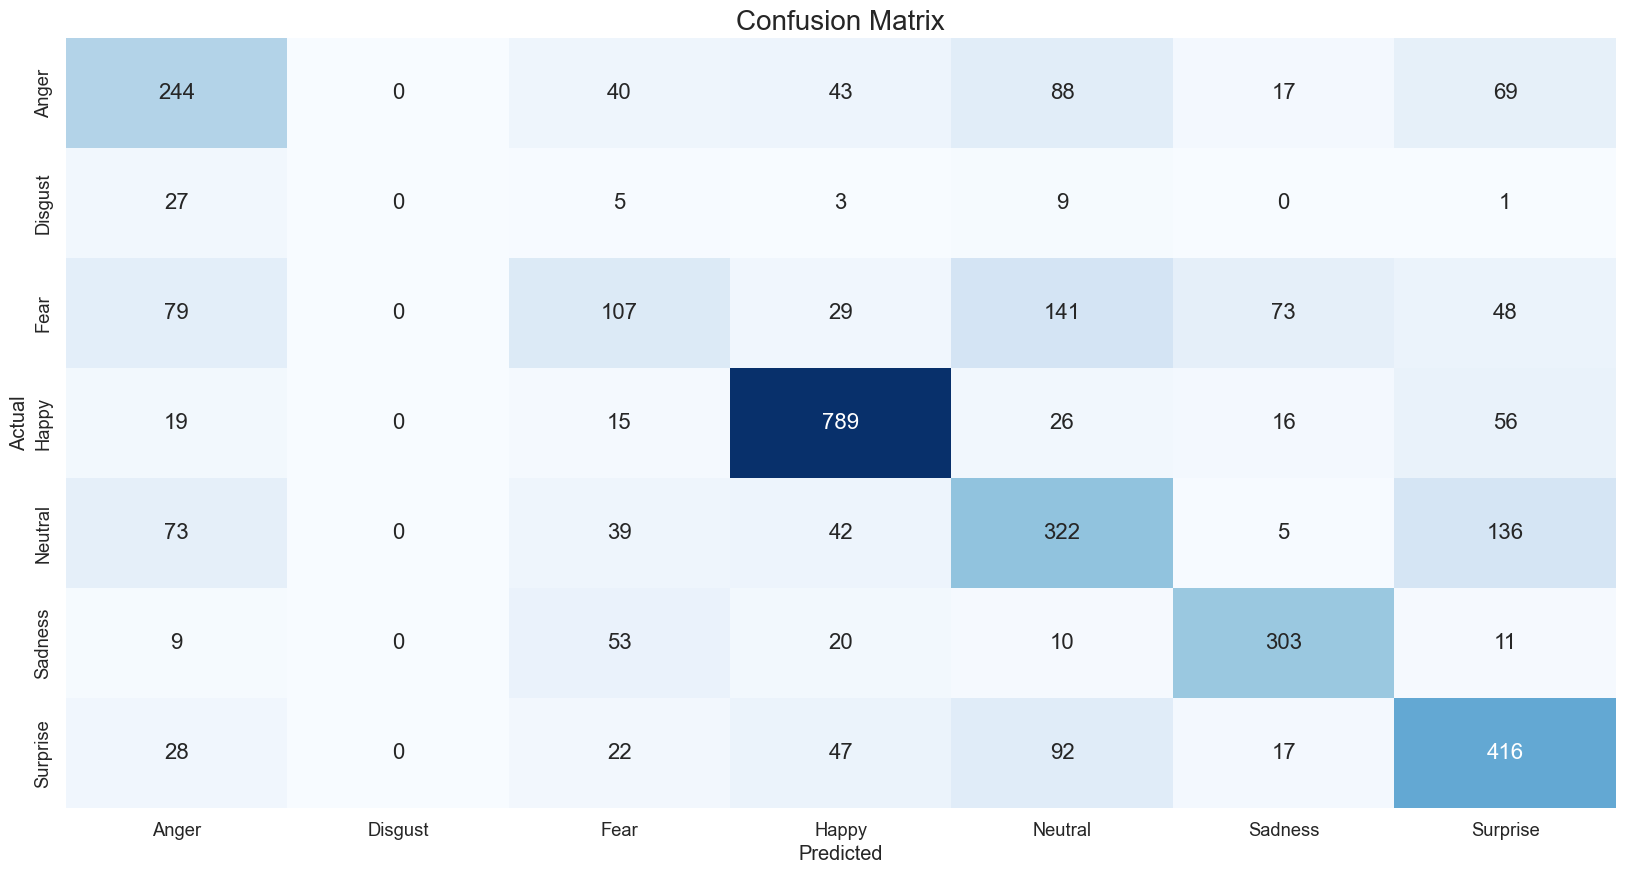

In [41]:
#CONFUSION MATRIX FOR OPTIMIZATION- PARAMETRIC TUNING USING ADAM, BATCH SIZE 16 AND INCREASED LR APROACH FROM 0.00001 TO LR 0.001
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']


cm_data = confusion_matrix(npy.argmax(y_test, axis = 1 ), y_pred)
cm = pda.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')


print(classification_report(npy.argmax(y_test, axis = 1 ),y_pred,digits=3))

In [35]:
#OPTIMIZATION- PARAMETRIC TUNING USING ADAM, BATCH SIZE 16 AND INCREASED LR APROACH FROM 0.00001 TO LR 0.002


model = cnn_model()
model.compile(
   optimizer = Adam(lr=0.002),
   loss='categorical_crossentropy',
   metrics=['accuracy'])


checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                             restore_best_weights=True,mode="max",patience = 10),
                             ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                             save_best_only=True,mode="max")]


history = model.fit(train_generator,
                   epochs=75,
                   batch_size=16,
                   verbose=1,
                   callbacks=[checkpointer],
                   validation_data=val_generator)


loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))


preds = model.predict(X_test)
y_pred = npy.argmax(preds , axis = 1 )

Epoch 1/75
455/455 [==============================] - ETA: 0s - loss: 6.6978 - accuracy: 0.2258
Epoch 1: val_accuracy improved from -inf to 0.20464, saving model to best_model.h5
455/455 [==============================] - 67s 143ms/step - loss: 6.6978 - accuracy: 0.2258 - val_loss: 2.7128 - val_accuracy: 0.2046
Epoch 2/75
455/455 [==============================] - ETA: 0s - loss: 2.4632 - accuracy: 0.3159
Epoch 2: val_accuracy improved from 0.20464 to 0.30774, saving model to best_model.h5
455/455 [==============================] - 63s 138ms/step - loss: 2.4632 - accuracy: 0.3159 - val_loss: 2.6771 - val_accuracy: 0.3077
Epoch 3/75
455/455 [==============================] - ETA: 0s - loss: 2.4996 - accuracy: 0.4053
Epoch 3: val_accuracy improved from 0.30774 to 0.39164, saving model to best_model.h5
455/455 [==============================] - 63s 137ms/step - loss: 2.4996 - accuracy: 0.4053 - val_loss: 2.4954 - val_accuracy: 0.3916
Epoch 4/75
455/455 [==============================] - E

Epoch 29/75
455/455 [==============================] - ETA: 0s - loss: 1.5039 - accuracy: 0.5582
Epoch 29: val_accuracy improved from 0.56378 to 0.56502, saving model to best_model.h5
455/455 [==============================] - 62s 136ms/step - loss: 1.5039 - accuracy: 0.5582 - val_loss: 1.5033 - val_accuracy: 0.5650
Epoch 30/75
455/455 [==============================] - ETA: 0s - loss: 1.4928 - accuracy: 0.5580
Epoch 30: val_accuracy improved from 0.56502 to 0.57523, saving model to best_model.h5
455/455 [==============================] - 62s 136ms/step - loss: 1.4928 - accuracy: 0.5580 - val_loss: 1.4495 - val_accuracy: 0.5752
Epoch 31/75
455/455 [==============================] - ETA: 0s - loss: 1.4769 - accuracy: 0.5621
Epoch 31: val_accuracy did not improve from 0.57523
455/455 [==============================] - 62s 136ms/step - loss: 1.4769 - accuracy: 0.5621 - val_loss: 1.4757 - val_accuracy: 0.5632
Epoch 32/75
455/455 [==============================] - ETA: 0s - loss: 1.4576 - a

              precision    recall  f1-score   support

           0      0.509     0.487     0.498       501
           1      0.000     0.000     0.000        45
           2      0.381     0.224     0.282       477
           3      0.811     0.857     0.833       921
           4      0.468     0.522     0.493       617
           5      0.703     0.746     0.724       406
           6      0.564     0.669     0.612       622

    accuracy                          0.608      3589
   macro avg      0.491     0.501     0.492      3589
weighted avg      0.588     0.608     0.594      3589



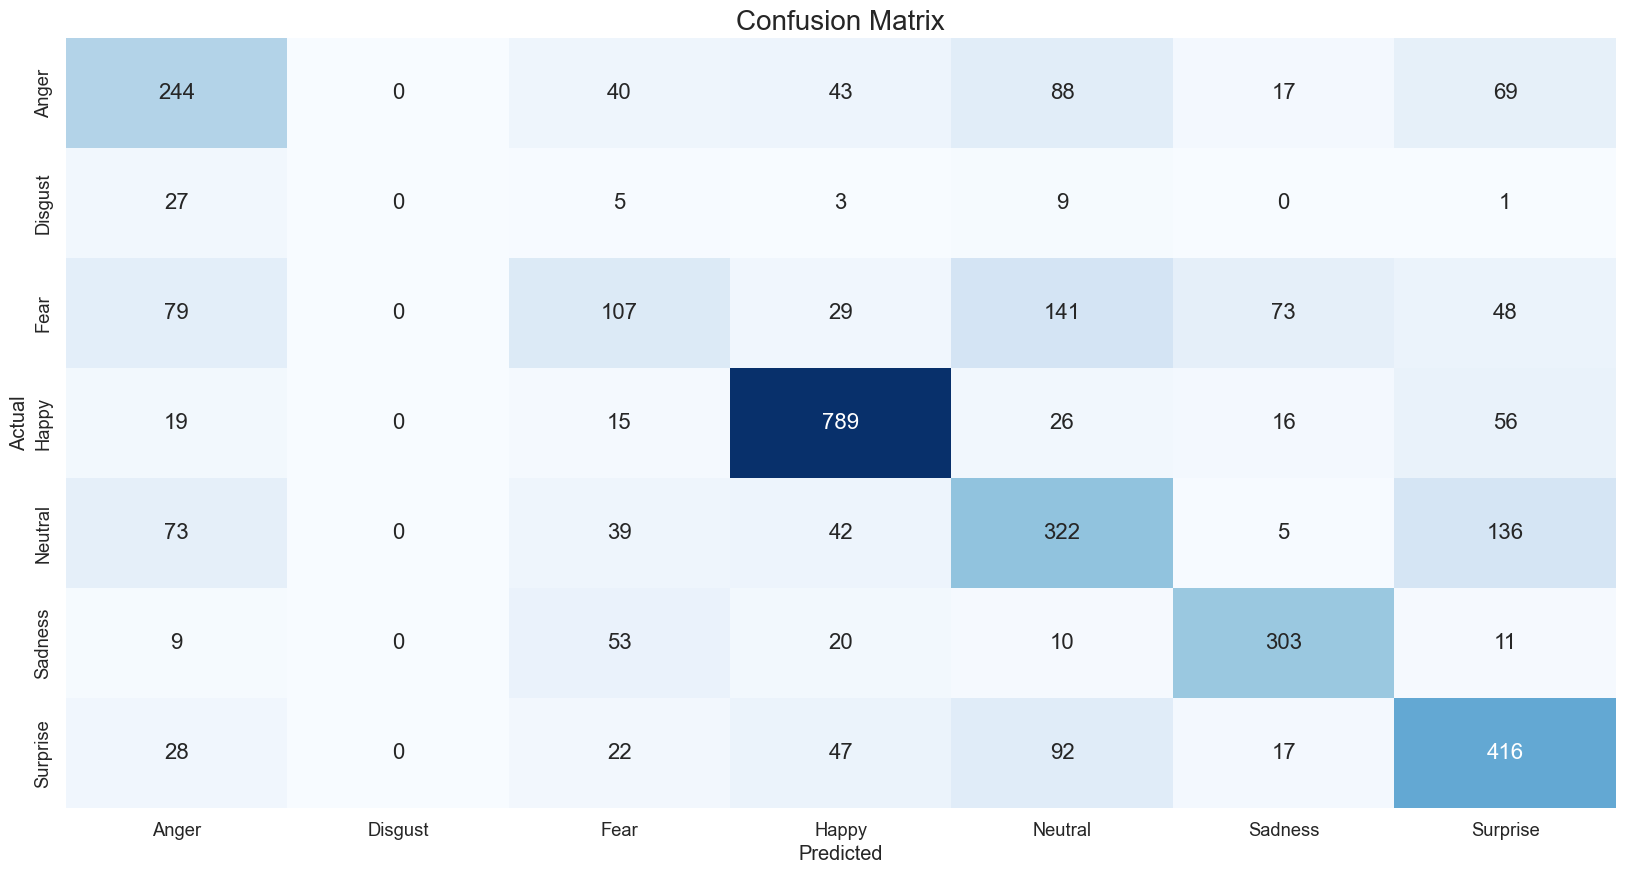

In [38]:
#CONFUSION MATRIX FOR OPTIMIZATION- PARAMETRIC TUNING USING ADAM, BATCH SIZE 16 AND INCREASED LR APROACH FROM 0.00001 TO LR 0.002
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']


cm_data = confusion_matrix(npy.argmax(y_test, axis = 1 ), y_pred)
cm = pda.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')


print(classification_report(npy.argmax(y_test, axis = 1 ),y_pred,digits=3))

In [36]:
#OPTIMIZATION- PARAMETRIC TUNING USING ADAM, BATCH SIZE 16 AND INCREASED LR APROACH FROM 0.00001 TO LR 0.0025


model = cnn_model()
model.compile(
   optimizer = Adam(lr=0.0025),
   loss='categorical_crossentropy',
   metrics=['accuracy'])


checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                             restore_best_weights=True,mode="max",patience = 10),
                             ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                             save_best_only=True,mode="max")]


history = model.fit(train_generator,
                   epochs=75,
                   batch_size=16,
                   verbose=1,
                   callbacks=[checkpointer],
                   validation_data=val_generator)


loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))


preds = model.predict(X_test)
y_pred = npy.argmax(preds , axis = 1 )

Epoch 1/75
455/455 [==============================] - ETA: 0s - loss: 6.3622 - accuracy: 0.2149
Epoch 1: val_accuracy improved from -inf to 0.25108, saving model to best_model.h5
455/455 [==============================] - 67s 143ms/step - loss: 6.3622 - accuracy: 0.2149 - val_loss: 2.3396 - val_accuracy: 0.2511
Epoch 2/75
455/455 [==============================] - ETA: 0s - loss: 2.2402 - accuracy: 0.2418
Epoch 2: val_accuracy did not improve from 0.25108
455/455 [==============================] - 62s 137ms/step - loss: 2.2402 - accuracy: 0.2418 - val_loss: 2.2303 - val_accuracy: 0.2505
Epoch 3/75
455/455 [==============================] - ETA: 0s - loss: 2.2764 - accuracy: 0.2908
Epoch 3: val_accuracy improved from 0.25108 to 0.27926, saving model to best_model.h5
455/455 [==============================] - 63s 138ms/step - loss: 2.2764 - accuracy: 0.2908 - val_loss: 2.4413 - val_accuracy: 0.2793
Epoch 4/75
455/455 [==============================] - ETA: 0s - loss: 2.3907 - accuracy: 0

Epoch 29/75
455/455 [==============================] - ETA: 0s - loss: 1.5190 - accuracy: 0.5522
Epoch 29: val_accuracy did not improve from 0.56842
455/455 [==============================] - 63s 139ms/step - loss: 1.5190 - accuracy: 0.5522 - val_loss: 1.5643 - val_accuracy: 0.5248
Epoch 30/75
455/455 [==============================] - ETA: 0s - loss: 1.4965 - accuracy: 0.5561
Epoch 30: val_accuracy did not improve from 0.56842
455/455 [==============================] - 63s 138ms/step - loss: 1.4965 - accuracy: 0.5561 - val_loss: 1.4974 - val_accuracy: 0.5619
Epoch 31/75
455/455 [==============================] - ETA: 0s - loss: 1.4846 - accuracy: 0.5578
Epoch 31: val_accuracy did not improve from 0.56842
455/455 [==============================] - 62s 137ms/step - loss: 1.4846 - accuracy: 0.5578 - val_loss: 1.4809 - val_accuracy: 0.5669
Epoch 32/75
455/455 [==============================] - ETA: 0s - loss: 1.4858 - accuracy: 0.5579
Epoch 32: val_accuracy improved from 0.56842 to 0.5789

              precision    recall  f1-score   support

           0      0.509     0.487     0.498       501
           1      0.000     0.000     0.000        45
           2      0.381     0.224     0.282       477
           3      0.811     0.857     0.833       921
           4      0.468     0.522     0.493       617
           5      0.703     0.746     0.724       406
           6      0.564     0.669     0.612       622

    accuracy                          0.608      3589
   macro avg      0.491     0.501     0.492      3589
weighted avg      0.588     0.608     0.594      3589



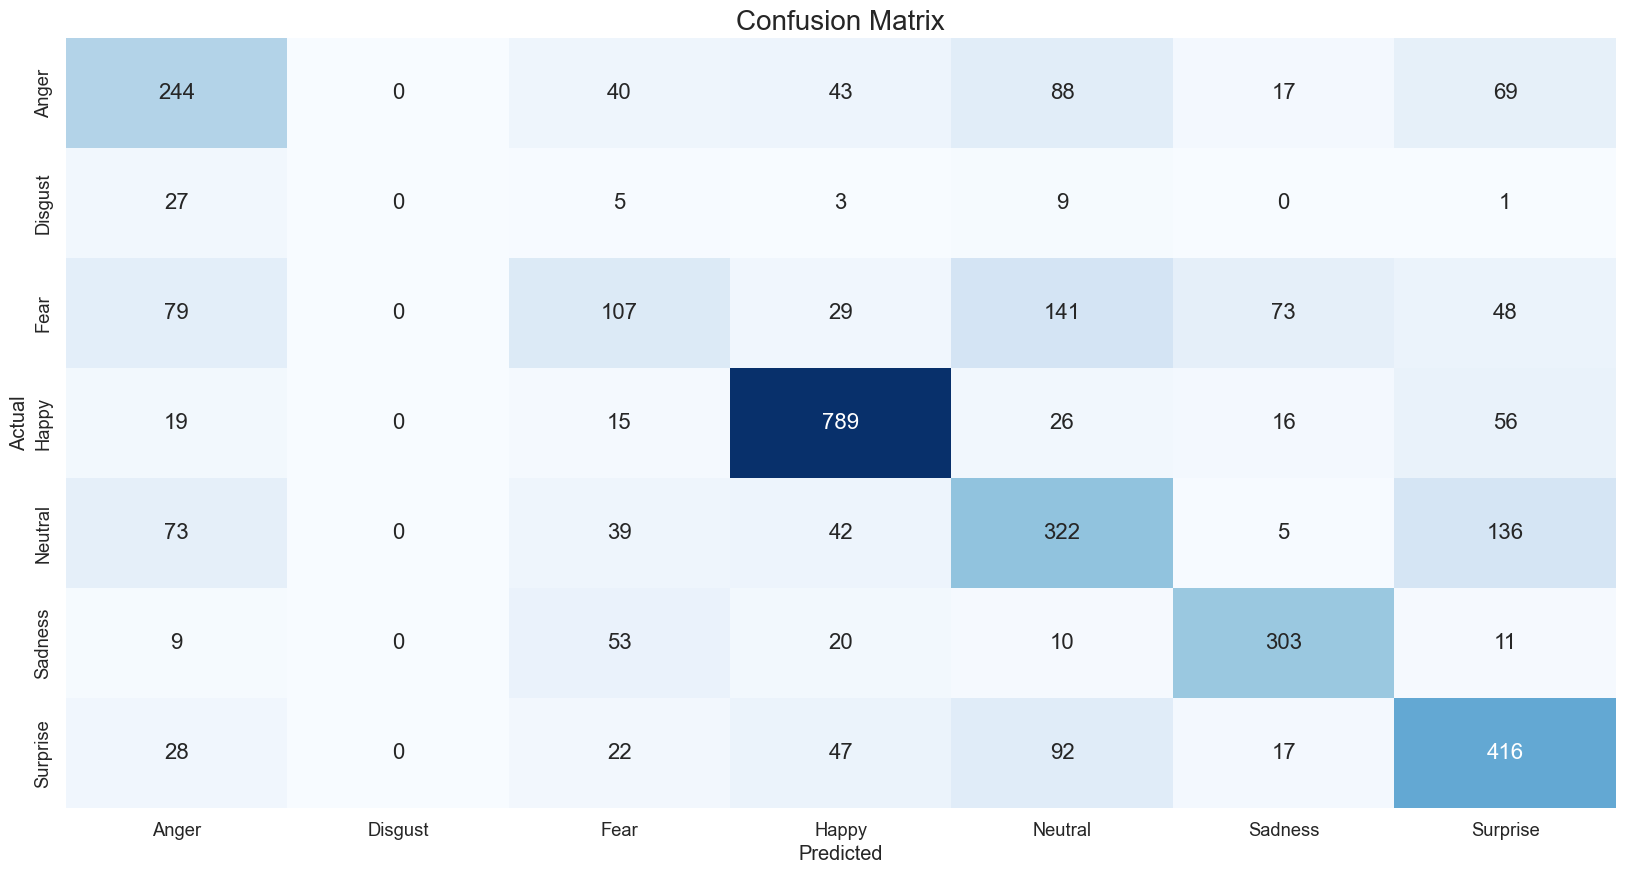

In [40]:
#CONFUSION MATRIX FOR OPTIMIZATION- PARAMETRIC TUNING USING ADAM, BATCH SIZE 16 AND INCREASED LR APROACH FROM 0.00001 TO LR 0.0025
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']


cm_data = confusion_matrix(npy.argmax(y_test, axis = 1 ), y_pred)
cm = pda.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')


print(classification_report(npy.argmax(y_test, axis = 1 ),y_pred,digits=3))

In [37]:
#OPTIMIZATION- PARAMETRIC TUNING USING ADAM, BATCH SIZE 16 AND INCREASED LR APROACH FROM 0.00001 TO LR 0.0021


model = cnn_model()
model.compile(
   optimizer = Adam(lr=0.0021),
   loss='categorical_crossentropy',
   metrics=['accuracy'])


checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                             restore_best_weights=True,mode="max",patience = 10),
                             ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                             save_best_only=True,mode="max")]


history = model.fit(train_generator,
                   epochs=75,
                   batch_size=16,
                   verbose=1,
                   callbacks=[checkpointer],
                   validation_data=val_generator)


loss = model.evaluate(X_test,y_test)
print("Test Acc: " + str(loss[1]))


preds = model.predict(X_test)
y_pred = npy.argmax(preds , axis = 1 )

Epoch 1/75
455/455 [==============================] - ETA: 0s - loss: 6.3684 - accuracy: 0.2273
Epoch 1: val_accuracy improved from -inf to 0.22074, saving model to best_model.h5
455/455 [==============================] - 69s 148ms/step - loss: 6.3684 - accuracy: 0.2273 - val_loss: 2.6767 - val_accuracy: 0.2207
Epoch 2/75
455/455 [==============================] - ETA: 0s - loss: 2.3412 - accuracy: 0.3031
Epoch 2: val_accuracy improved from 0.22074 to 0.31393, saving model to best_model.h5
455/455 [==============================] - 62s 137ms/step - loss: 2.3412 - accuracy: 0.3031 - val_loss: 2.7190 - val_accuracy: 0.3139
Epoch 3/75
455/455 [==============================] - ETA: 0s - loss: 2.4985 - accuracy: 0.3894
Epoch 3: val_accuracy improved from 0.31393 to 0.34954, saving model to best_model.h5
455/455 [==============================] - 62s 137ms/step - loss: 2.4985 - accuracy: 0.3894 - val_loss: 2.6750 - val_accuracy: 0.3495
Epoch 4/75
455/455 [==============================] - E

455/455 [==============================] - 62s 137ms/step - loss: 1.5063 - accuracy: 0.5569 - val_loss: 1.5128 - val_accuracy: 0.5529
Epoch 29/75
455/455 [==============================] - ETA: 0s - loss: 1.4907 - accuracy: 0.5582
Epoch 29: val_accuracy improved from 0.56378 to 0.56594, saving model to best_model.h5
455/455 [==============================] - 62s 137ms/step - loss: 1.4907 - accuracy: 0.5582 - val_loss: 1.4837 - val_accuracy: 0.5659
Epoch 30/75
455/455 [==============================] - ETA: 0s - loss: 1.4905 - accuracy: 0.5584
Epoch 30: val_accuracy improved from 0.56594 to 0.57121, saving model to best_model.h5
455/455 [==============================] - 62s 137ms/step - loss: 1.4905 - accuracy: 0.5584 - val_loss: 1.4837 - val_accuracy: 0.5712
Epoch 31/75
455/455 [==============================] - ETA: 0s - loss: 1.4768 - accuracy: 0.5581
Epoch 31: val_accuracy did not improve from 0.57121
455/455 [==============================] - 63s 138ms/step - loss: 1.4768 - accura

              precision    recall  f1-score   support

           0      0.509     0.487     0.498       501
           1      0.000     0.000     0.000        45
           2      0.381     0.224     0.282       477
           3      0.811     0.857     0.833       921
           4      0.468     0.522     0.493       617
           5      0.703     0.746     0.724       406
           6      0.564     0.669     0.612       622

    accuracy                          0.608      3589
   macro avg      0.491     0.501     0.492      3589
weighted avg      0.588     0.608     0.594      3589



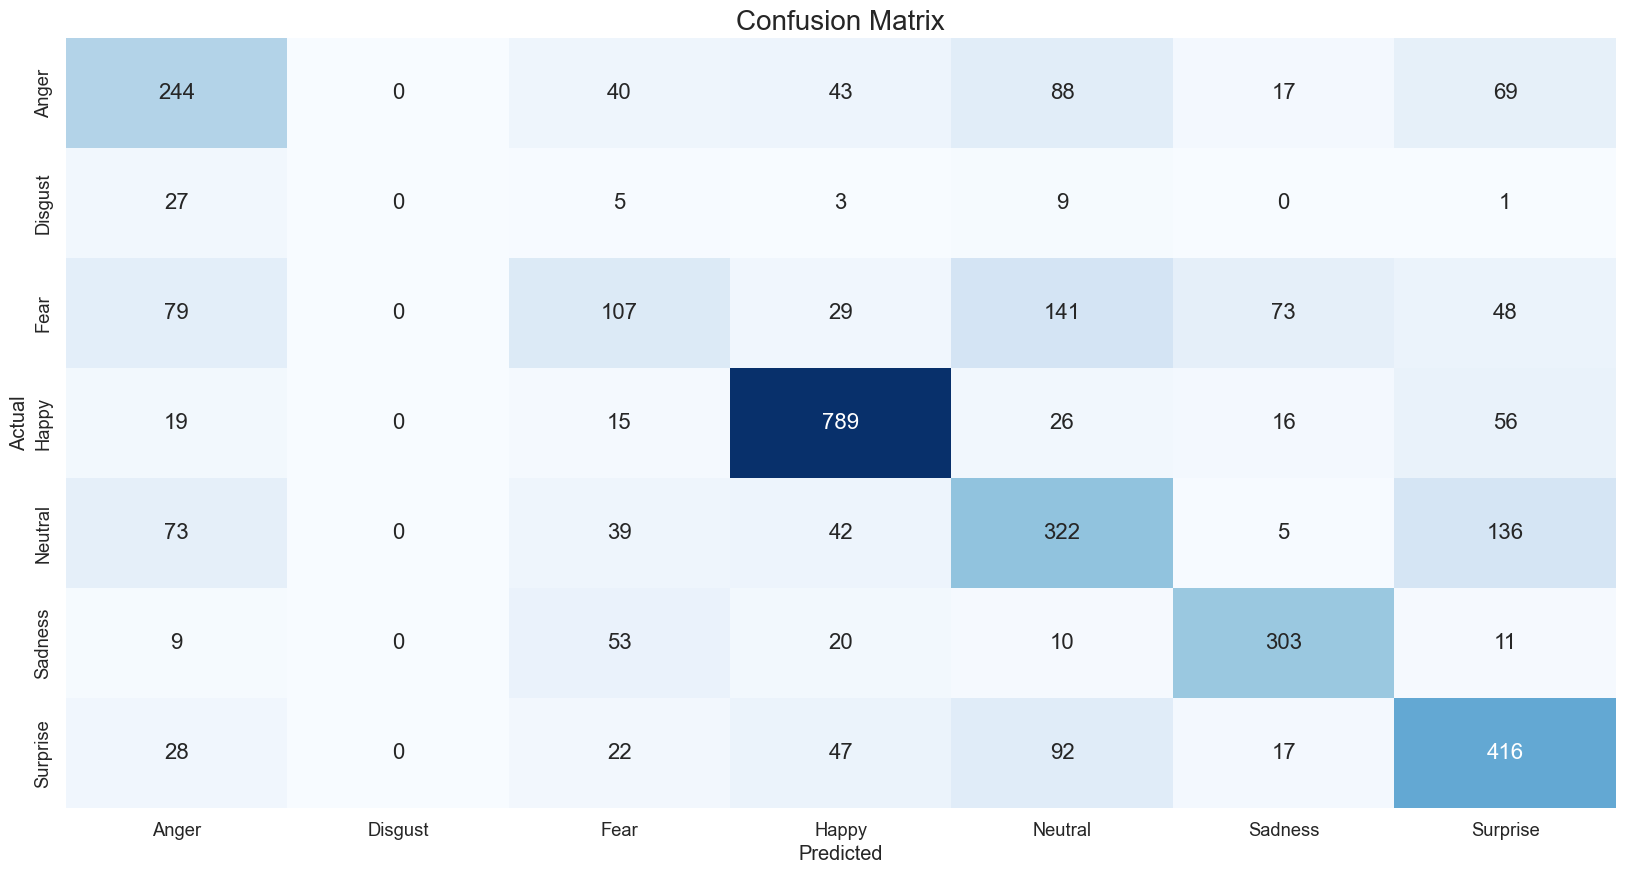

In [39]:
#CONFUSION MATRIX FOR OPTIMIZATION- PARAMETRIC TUNING USING ADAM, BATCH SIZE 16 AND INCREASED LR APROACH FROM 0.00001 TO LR 0.0021
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']


cm_data = confusion_matrix(npy.argmax(y_test, axis = 1 ), y_pred)
cm = pda.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')


print(classification_report(npy.argmax(y_test, axis = 1 ),y_pred,digits=3))